# `Практикум по программированию на языке Python`

## `Задание 02. Сегментация изображений`

#### Фамилия, имя: Кривуля Полина

Дата выдачи: <span style="color:red">__18 марта 17:00__</span>.

Мягкий дедлайн: <span style="color:red">__01 апреля 23:59__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __4.25 балла__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2023`

В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур `U-Net` и `LinkNet`. 

Данные для выполнения задания можно скачать по [ссылке](https://disk.yandex.ru/d/tI6d3LBMHTwOnw).

## `Загрузка данных (1 балл)`

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с ImageNet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс `PhotosDataset` для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [46]:
!pip install matplotlib_inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
import os

import numpy as np
import numpy.testing as npt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg13, VGG13_Weights

import matplotlib_inline
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [48]:
from torchvision import transforms
from torchvision.transforms import Compose

In [49]:
class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms=None):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images
            
        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name, but different format.
            
        transforms : some collection
            Sequence of transformations for images and masks. 
        """
        # your code here
        self.images_dir = images_dir
        self.target_dir = target_dir
        if transforms is not None:
            self.transforms = Compose(transforms)
        else:
            self.transforms = Compose([])
        self.images_paths = sorted([os.path.abspath(images_dir + '/' + x) for x in os.listdir(images_dir)])
        self.target_path = []
        if target_dir is not None:
            self.target_path = sorted([os.path.abspath(target_dir + '/' + x) for x in os.listdir(target_dir)])
        
    def __len__(self):
        # your code here
        return len(self.images_paths)
                   
    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask
        
        Returns
        -------
        (image, mask)
        """
        # your code here
        image = Image.open(self.images_paths[idx])
        if self.target_dir is None:
            return (image, None)
        mask = Image.open(self.target_path[idx])
        return self.transforms((image, mask))

## `Модуль аугментации (2 балла)`

Конструктор стандартного `ImageFolder`, принимает параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в [документации](https://pytorch.org/vision/0.12/transforms.html).

В данной части вам предлагается самостоятельно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

* случайное (с вероятностью $p$) горизонтальное отображение (flip) изображения 
* случайное (с вероятностью $p$) вырезание фрагмента изображения (заданного или случайного размера)
* случайное (с вероятностью $p$) изменение яркости изображения (на заданную или случайную величину)
* случайное (с вероятностью $p$) изменение фона изображения (на изображение из заданного списка изображений)

In [50]:
# your code here
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method > torch.rand(1):
            return (img[0].transpose(Image.FLIP_LEFT_RIGHT), img[1].transpose(Image.FLIP_LEFT_RIGHT))
        return img


class Crop(object):
    def __init__(self, mode=0, size=None):
        self.method = mode
        self.size = size
    
    def __call__(self, img):
        
        if self.method < torch.rand(1):
            return img
        if self.size is None:
            self.size = [torch.randint(0, img[0].size[0] + 1, (1, )).item(), 
                         torch.randint(0, img[0].size[1] + 1, (1, )).item()]
        # crop(img, top, left, height, width)
        top = torch.randint(0, - self.size[0] + img[0].size[0] + 1, (1,)).item()
        left = torch.randint(0, - self.size[1] + img[1].size[1] + 1, (1,)).item()
        return (img[0].crop(list([top, left, top + self.size[0], left + self.size[1]])).resize((img[0].size)), 
                img[1].crop(list([top, left, top + self.size[0], left + self.size[1]])).resize((img[1].size)))


class BrightnessChange(object):
    def __init__(self, mode=0, brightness=None):
        self.method = mode
        if brightness is None:
            self.brightness = torch.rand(1).item() * 1.5 + 0.3
        else:
            self.brightness = brightness
    
    def __call__(self, img):
        if self.method > torch.rand(1):
            return (ImageEnhance.Brightness(img[0]).enhance(self.brightness), img[1])
        return img
    
class BackgroundChange(object):
    def __init__(self, mode=0, img_background=None):
        self.method = mode
        self.img_background = img_background
    
    def __call__(self, img):
        if self.img_background is None:
            return img
        if self.method > torch.rand(1):
            num = torch.randint(0, len(self.img_background), (1, )).item()
            background = (Image.open(self.img_background[num])).resize(img[0].size)
            return (Image.composite(img[0], background, img[1]), img[1])
        return (img[0], img[1])

Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```python
transforms.ToTensor()
transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
```

In [51]:
class ImageToTensor:
    def __init__(self):
        self.to_tensor = transforms.ToTensor()

    def __call__(self, img):
        return (self.to_tensor(img[0]), self.to_tensor(img[1]))


class ImageNormalize:
    def __init__(self, mean, std):
        self.normalize = transforms.Normalize(mean, std)
        
    def __call__(self, img):
        return (self.normalize(img[0]), img[1])

In [52]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
%cd  /content/drive/MyDrive/people_data

/content/drive/MyDrive/people_data


In [55]:
DATA_PATH = './'

mean = 0.5
background = os.listdir(DATA_PATH + 'train/')
background = [os.path.join(DATA_PATH + 'train/', x) for x in background]

train_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'train'),
    target_dir=os.path.join(DATA_PATH, 'train_mask'),
    transforms=[HorizontalFlip(mean), Crop(mean, size=(200, 250)), BrightnessChange(mean), 
                BackgroundChange(mean, background), ImageToTensor(), ImageNormalize(mean, std)]
)

test_dataset = PhotosDataset(
    images_dir=os.path.join(DATA_PATH, 'test'),
    target_dir=os.path.join(DATA_PATH, 'test_mask'),
    transforms=[ImageToTensor(), ImageNormalize(mean, std)] 
)

Функция для отображения изображения:

In [56]:
def show_idx_image(dataset, idx):
    image, mask = dataset[idx]

    image = image.permute(1, 2, 0).numpy()
    image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)

    mask = mask.squeeze(0).numpy()

    fig, axes = plt.subplots(1, 2, figsize=(6, 4))

    axes[0].imshow(image)
    axes[1].imshow(mask)
    
    axes[0].set_axis_off()
    axes[1].set_axis_off()
    
    fig.tight_layout()
    plt.show()

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных.

In [57]:
import os
from PIL import Image
from PIL import ImageEnhance

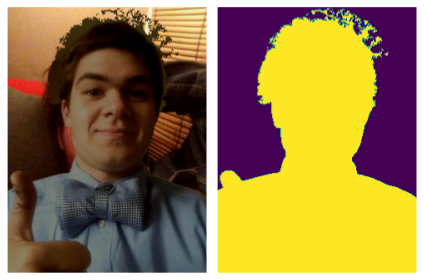

In [58]:
# your code here
show_idx_image(train_dataset, 1)

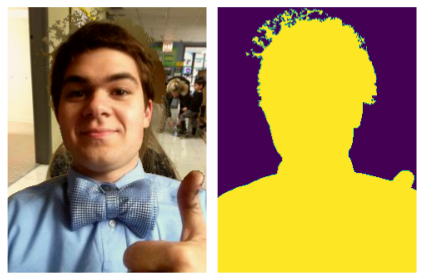

In [59]:
show_idx_image(train_dataset, 1)

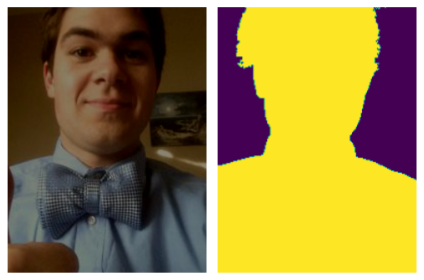

In [60]:
show_idx_image(train_dataset, 1)

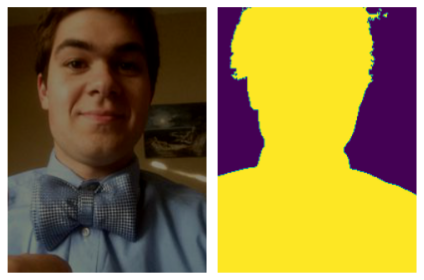

In [61]:
show_idx_image(train_dataset, 1)

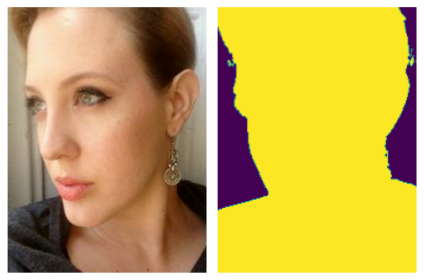

In [62]:
show_idx_image(train_dataset, 2)

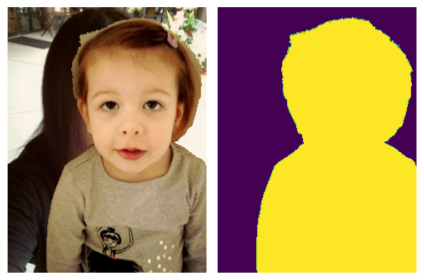

In [63]:
show_idx_image(train_dataset, 3)

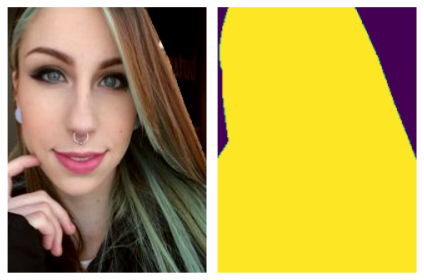

In [64]:
show_idx_image(train_dataset, 4)

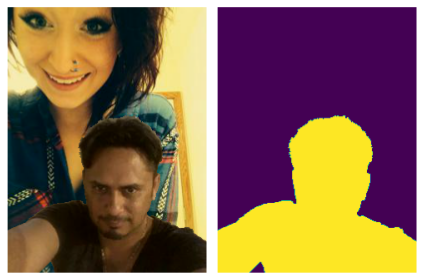

In [65]:
show_idx_image(train_dataset, 130)

## `Загрузчики`

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры `DataLoader`. При `num_workers`$\;> 1$, батчи готовятся (загружаются картинки, обрабатываются и так далее) сразу в нескольких фоновых процессах. С помощью параметра `shuffle` можно подавать картинки на обучение в случайном порядке.

Обычно, скорость обработки данных на GPU превышает скорость загрузки данных в одном процессе, поэтому типичное значение для `num_workers`$\approx 3\text{-}10$. 

Учтите, что на некоторых системах в Jupyter Notebook при `num_workers`$>0$ `DataLoader` перестаёт работать. В таком случае установите это значение в $0$.

In [66]:
test_data_loader = DataLoader(test_dataset, batch_size=8, num_workers=3)
train_data_loader = DataLoader(train_dataset, batch_size=8, num_workers=3, shuffle=True)

## `DiceLoss (1 балл)`

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через `torch.nn.Module`. В ячейке ниже вам предлагается реализовать функцию потерь `dice` (аналог меры Жаккарда).

Результат **Dice Loss** определим как:

$$
\text{Dice Coefficient} = 2\frac{|A \cap B| }{|A| + |B|} \leadsto \text{Dice Loss} = 1 - \frac{2\sum\limits_{i, j}a_{ij}b_{ij}}{\sum\limits_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — истинная разметка для пикселя изображения.

In [67]:
class DiceLoss(torch.nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of elements in the batch
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        
    def forward(self, logits, true_labels):
        """
        Arguments
        ---------
        logits: torch.Tensor
            Unnormalized probability of true class. Shape: [B, ...]
        true_labels: torch.Tensor
            Mask of correct predictions. Shape: [B, ...]
        Returns
        -------
        torch.Tensor
            If reduction is 'mean' or 'sum' returns a tensor with a single element
            Otherwise, returns a tensor of shape [B]
        """
        true_labels = true_labels.to(torch.long)
        
        if self.with_logits:
            # your code here
            logits = torch.sigmoid(logits)
        
        # your code here
        loss_value = 1 - 2 * (logits * true_labels).sum(axis=(1, 2)) / ((
            logits + true_labels).sum(axis=(1,2)) + self.eps)

        if self.reduction == 'sum':
            # your code here
            loss_value = torch.sum(loss_value) 
        elif self.reduction == 'mean':
            # your code here
            loss_value = torch.mean(loss_value)
        elif self.reduction is None:
            # your code here
            # loss_value = ...
            pass
            
        return loss_value

Проверка реализации:

In [68]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## `U-Net (3 балла)`

Для решения задачи сегментации будем использовать [U-Net](https://arxiv.org/pdf/1505.04597.pdf) с энкодером из первых блоков предобученного `VGG13`.

Концептуальная схема представлена на диаграмме ниже:

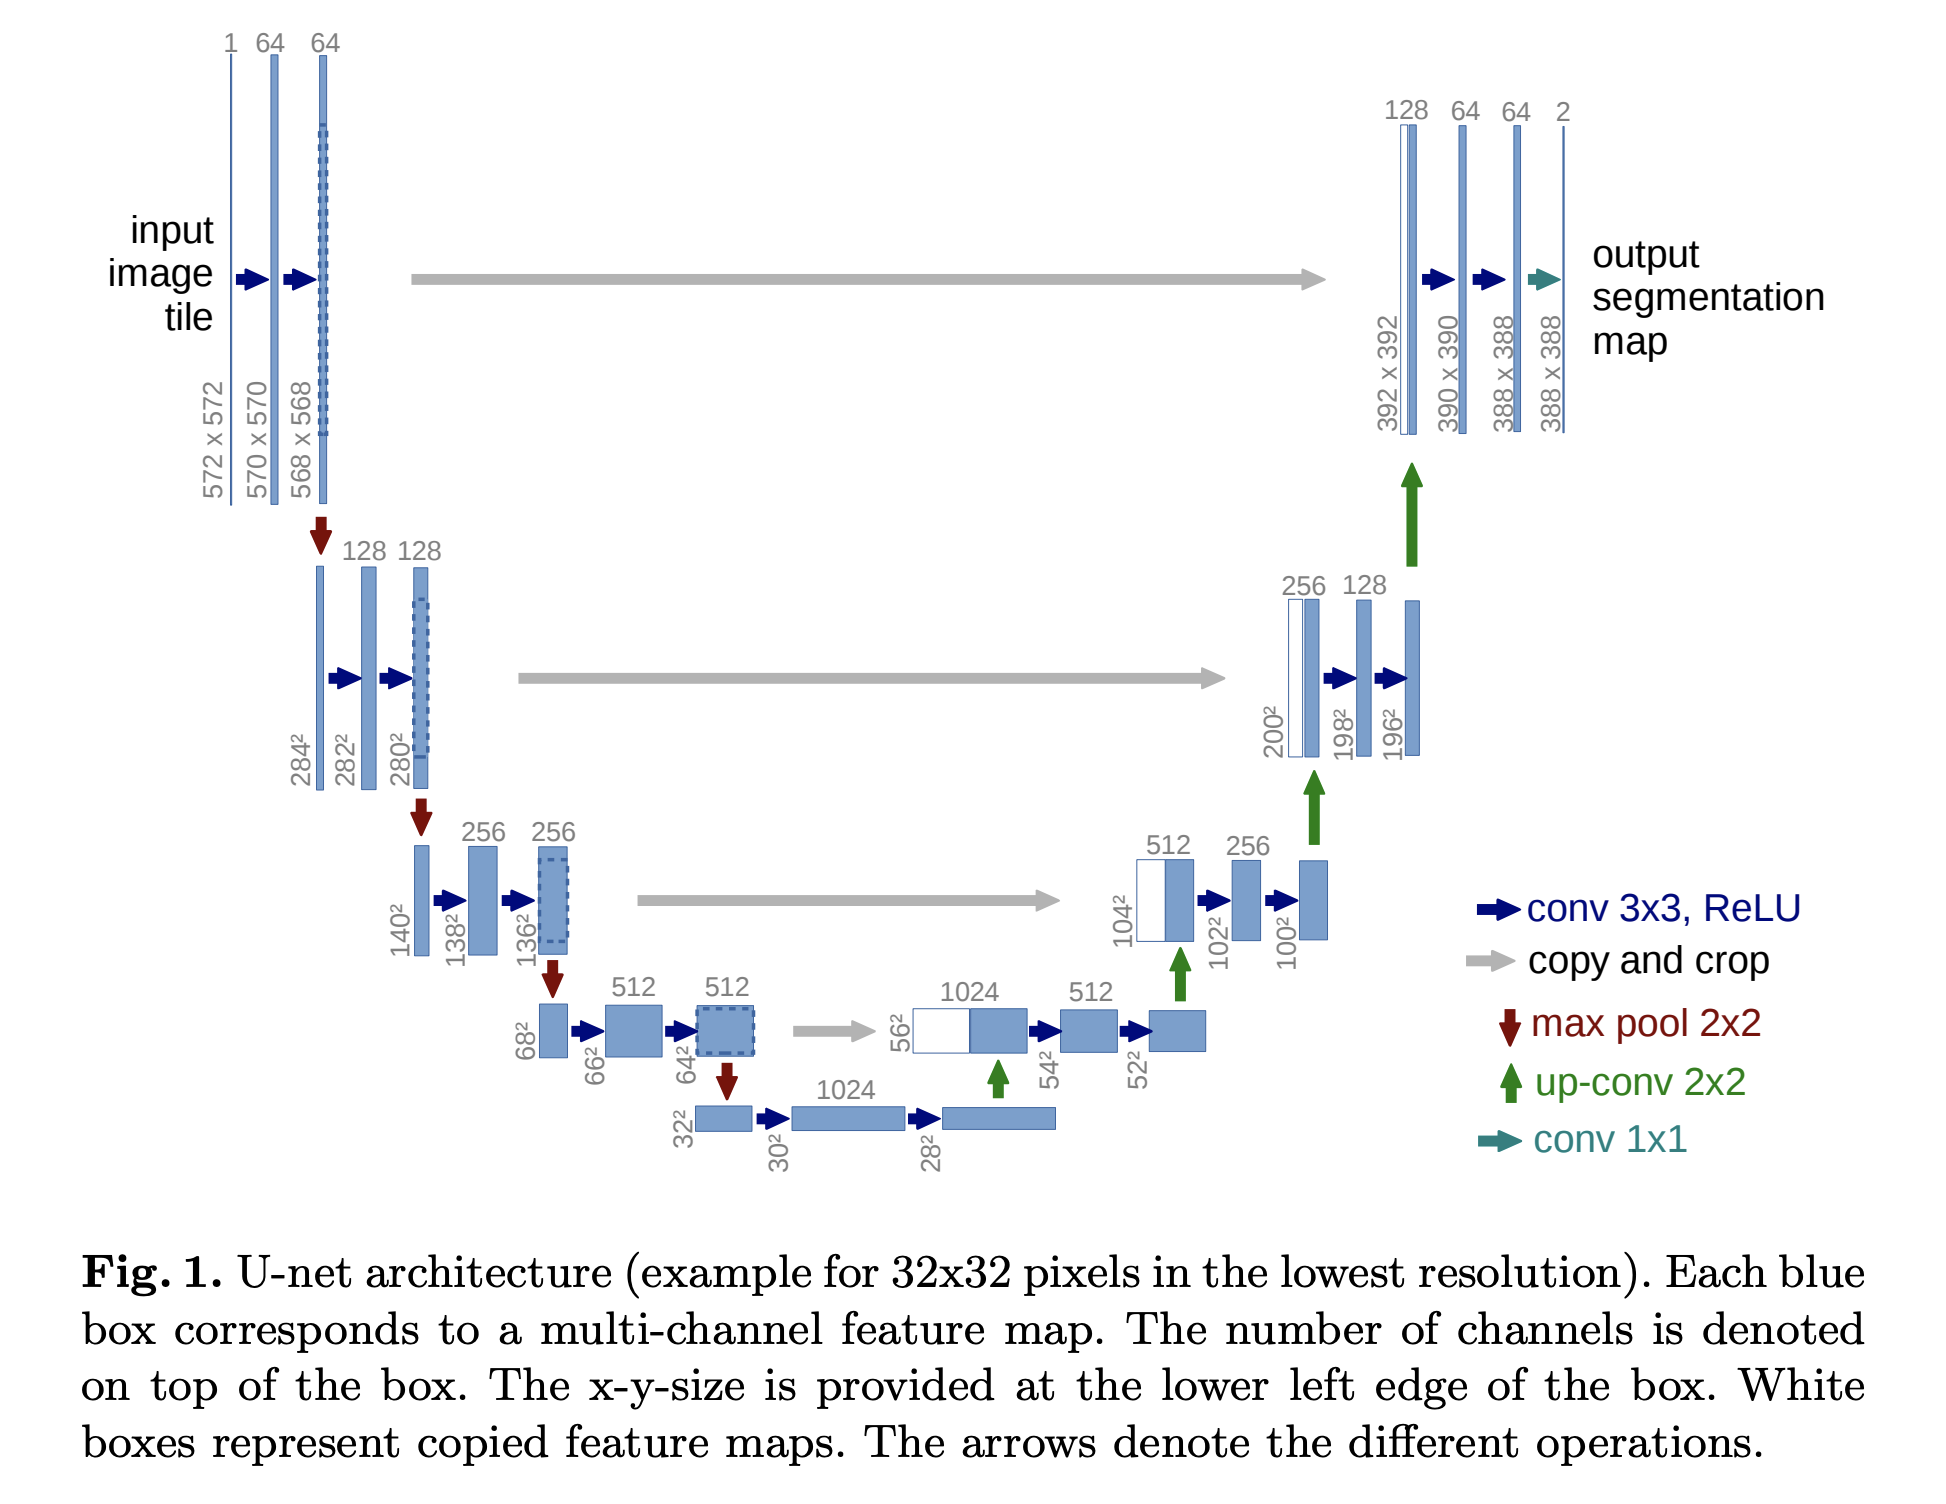

Заметим, что блоки VGG13 имеют следующий вид:
```python
    (0): Conv2d(...)
    (1): ReLU(...)
    (2): Conv2d(...)
    (3): ReLU(...)
    (4): MaxPool2d(...)
```

Для удобства, уберём слои `MaxPool2d` из блоков энкодера и будем применять pooling отдельно.

Реализуйте архитектуру данной сети.

#### `Encoder`

In [69]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, weights=VGG13_Weights.DEFAULT):
        super().__init__()
        self.num_blocks = num_blocks
        
        # Будем использовать предобученную VGG13 в качестве backbone
        feature_extractor = vgg13(weights=weights).features
        
        # Каждый блок энкодера U-Net — это блок VGG13 без MaxPool2d
        self.blocks = torch.nn.ModuleList()
        for idx in range(self.num_blocks):
            # Возьмите нужные слои из `feature_extractor` для очередного U-Net блока
            # Объедините их с помощью `torch.nn.Sequential`
            layers = []
            for i in range(idx * 5, idx * 5 + 4):
                layers.append(feature_extractor[i])
            self.blocks.append(torch.nn.Sequential(*layers))

    def forward(self, x):
        activations = []
        for idx, block in enumerate(self.blocks):
            # Примените очередной блок U-Net
            # your code here
            x = block(x)

            # Сохраните активации для передачи их в декодер
            # your code here
            activations.append(x)

            # При необходимости примените max-pool
            # Можно использовать `torch.functional.F.max_pool2d`
            # your code here
            if idx != len(self.blocks) - 1:
                x = torch.functional.F.max_pool2d(x, 2)
            
        return activations

In [70]:
assert sum((param.numel() for param in VGG13Encoder(num_blocks=1).parameters())) == 38720
assert sum((param.numel() for param in VGG13Encoder(num_blocks=2).parameters())) == 260160
assert sum((param.numel() for param in VGG13Encoder(num_blocks=3).parameters())) == 1145408

x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)
out = VGG13Encoder(num_blocks=3)(x)

assert len(out) == 3
npt.assert_almost_equal(torch.linalg.norm(out[0]).item(), 902.218, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[1]).item(), 571.030, decimal=3)
npt.assert_almost_equal(torch.linalg.norm(out[2]).item(), 648.068, decimal=3)

#### `Decoder`

In [71]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = torch.nn.ReLU()
        
    def forward(self, down, left):
        # Upsample x2 и свёртка
        # your code here
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        
        # Конкатенация выхода энкодера и предыдущего блока декодера
        # your code here
        x = self.upconv(x)
        
        # Две свёртки с ReLu
        # your code here
        x = self.conv2(self.conv1(torch.cat([left, x], 1)))

        return x

In [72]:
class Decoder(torch.nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        self.blocks = torch.nn.ModuleList()
        for idx in range(num_blocks):
            self.blocks.insert(0, DecoderBlock(num_filters * 2 ** idx))

    def forward(self, acts):
        up = acts[-1]
        for block, left in zip(self.blocks, acts[-2::-1]):
            up = block(up, left)
        return up

#### `U-Net`

In [73]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_blocks=4):
        super().__init__()
        # your code here
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        
        # your code here
        self.decoder = Decoder(num_filters=64, num_blocks=num_blocks-1)
        
        # Свёртка 1x1 для попиксельной агрегации каналов
        # your code here
        self.final = torch.nn.Conv2d(
            in_channels=64,
            out_channels=num_classes,
            kernel_size=1)

    def forward(self, x):
        # your code here
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.final(x)

        return x

In [74]:
model = UNet(num_classes=1, num_blocks=3)
x = torch.arange(1 * 3 * 320 * 240).reshape(1, 3, 320, 240) / (1 * 3 * 320 * 240)

assert sum((param.numel() for param in model.parameters())) == 2067649
assert list(model(x).shape) == [1, 1, 320, 240]
model

UNet(
  (encoder): VGG13Encoder(
    (blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (2): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0): DecoderBlock(
        (upconv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       

### `Оценивание качества сети`


Обычно, оптимизируемый функционал сложно интерпретировать, а так же в разных экспериментах могут использоваться разные функции потерь. Поэтому необходимо замерять и отслеживать независимую метрику качества. Предлагается использовать **IoU (Intersection over Union)** — один из стандартных вариантов для задачи сегментации:
$$
\text{IoU} = \frac{|A \cap B|}{|A \cup B|} = \frac{\sum\limits_{ij}a_{ij}b_{ij}}{\sum\limits_{ij}a_{ij} + b_{ij} - a_{ij}b_{ij}}
$$

In [75]:
class IoUScore(torch.nn.Module):
    def __init__(self, threshold, reduction=None):
        """
        Arguments
        ---------
        threshold : float
            threshold for logits binarization
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of elements in the batch
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        
        self.threshold = threshold
        self.reduction = reduction
        
    @torch.no_grad()
    def forward(self, logits, true_labels):
        """
        Arguments
        ---------
        logits: torch.Tensor
            Unnormalized probability of true class. Shape: [B, ...]
        true_labels: torch.Tensor
            Mask of correct predictions. Shape: [B, ...]
        Returns
        -------
        torch.Tensor
            If reduction is 'mean' or 'sum' returns a tensor with a single element
            Otherwise, returns a tensor of shape [B]
        """
        # your code here
        true_labels = true_labels.bool()
        pred = logits > self.threshold
        score = (pred & true_labels).sum(axis=(1, 2)) / (pred | true_labels).sum(axis=(1,2))

        if self.reduction == 'sum':
            # your code here
            score = torch.sum(score)
        elif self.reduction == 'mean':
            # your code here
            score = torch.mean(score)
            
        return score

In [76]:
logits = torch.tensor([
    [
        [0.3089,  0.4311, -0.9711],
        [0.9030,  1.0325, -0.7607],
        [0.9648, -0.5528, -1.1010]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ], [
        [0.8906,  0.8099,  0.4458],
        [2.6215, -1.3198,  0.3142],
        [0.2262, -0.9175, -0.0174]
    ]
])
true_labels = torch.tensor([
    [
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.]
    ], [
        [1., 1., 1.],
        [1., 0., 1.],
        [1., 0., 0.]
    ], [
        [1., 1., 1.],
        [0., 1., 1.],
        [1., 1., 1.]
    ]
])

scores = IoUScore(0.0)(logits, true_labels)
npt.assert_almost_equal(scores.numpy(), np.array([0.3333, 1.0000, 0.5556]), decimal=4)

score = IoUScore(0.0, reduction='sum')(logits, true_labels)
npt.assert_almost_equal(score.item(), 1.8889, decimal=4)

score = IoUScore(0.0, reduction='mean')(logits, true_labels)
npt.assert_almost_equal(score.item(), 0.6296, decimal=4)

### `Tensorboard и логирование`

Для отслеживания процесса обучения обычно требуется сохранять информацию разных его аспектах.

Для полного контроля над процессом обучения обычно требуется сохранять информацию о разных статистиках. Самыми очевидными являются:
1. Значение функции потерь (лосса) на обучающей и тестовой выборках
2. Метики качества, например, **Dice Coefficient** и **IoU (Intersection over Union)** на обучающей и тестовой выборках

Однако, суррогатные метрики могут не отражать реального качества. Поэтому для моделей, которые выдают визуализируемый результат, обычно логируют предсказания для некоторых объектов выборки. В задаче сегментации естественным вариантом является логирование четвёрки: исходное изображение, истинная маска, маска вероятностей истинного класса, бинаризованная маска. 

*Замечание:* лосс и качество на обучающей выборке обычно логируют не только в конце каждой эпохи, но и по отдельным батчам на каждой итерации.

3. Чтобы отслеживать динамику обучения необходимо зафиксировать небольшой набор объектов обучающей и тестовой выборок и после каждой эпохи обучения логировать указанные четыре картинки для каждого объекта.

*Замечание:* можно логировать четвёрки изображений независимо, однако, удобнее объединить их на одной [фигуре](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_figure). Дополнительный плюс — возможность подписать значения метрик для этого объекта в заголовке изображения или добавить colorbar для более простой интерпретации предсказанной маски.

Для удобной категоризации экспериментов обычно в начале обучения сохраняют:

4. [Гиперпараметры модели](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_hparams) 
5. [Структуру модели](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_graph)

Для исследования технических особенностей обучения полезно логировать следующие статистики:

6. [Распределение весов, активаций, градиентов](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_histogram). Сохранять гистограммы каждого параметра после каждой итерации может быть вычислительно неэффективно, поэтому обычно сохраняют распределения весов для каждого отдельного слоя нейронной сети после каждой эпохи. 
7. Норма весов и норма градиента на каждой итерации

Наконец, после каждой эпохи можно визуализировать промежуточные представления входных данных:

8. Активации после каждого слоя/блока, как изображения
9. Градиенты функции потерь по активациям для некоторых объектов обучающей выборки, как изображения

*Замечание:* для реализации пунктов 8, 9 менять код модели не требуется. Используйте хуки: [register_full_backward_hook](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook), [register_forward_hook](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_forward_hook).

При реализации цикла обучения необходимо сохранять метрики $1\text{-}9$ с использованием модуля [torch.utils.tensorboard](https://pytorch.org/docs/stable/tensorboard.html). Файлы с логами, а также чекпоинты весов модели после итерации с наилучшим валидационным качеством (смотрите [torch.save](https://pytorch.org/docs/stable/generated/torch.save.html) и [torch.nn.Module.state_dict](https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html)) для **ВСЕХ** проведённых экспериментов (за исключением упавших, недосчитанных и так далее) необходимо сдать в anytask.

### `Эксперименты`

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке. 

Сначала при обучении используйте только кросс-энтропию (`torch.nn.BCEWithLogitsLoss` будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации:
1. Только кросс-энтропия
2. Только dice loss
3. Сумма двух лоссов с весами (попробуйте $3\text{-} 4$ разных соотношения)

**Для всех экспериментов отобразите графики функции потерь и качества за время обучения. Выведите получившиеся маски для нескольких изображений из датасета. Сделайте выводы.**

In [77]:
import torchvision.transforms as T
from collections import defaultdict

In [78]:
class partial_1:
  def __init__(self, activations, name):
    self.activations = activations
    self.name = name
  def __call__(self, model, input_grad, output_grad):
    sum_grad = 0
    for i in range(len(output_grad)):
      sum_grad += output_grad[i]
    self.activations[self.name] = list(sum_grad.to(device))

class partial_2:
  def __init__(self, activations, name):
    self.activations = activations
    self.name = name
  def __call__(self, model, input_grad, output_grad):
    self.activations[self.name] = list(output_grad.to(device))

In [79]:
# your code here
def train(model, dl_train, dl_test, n_epochs, loss_fn, optimizer, writer, nnname, print_res=False):
  loss_all, iou_all = [], []
  loss_test, iou_test = [], []
  criterion = IoUScore(0, 'mean')
  lr = 1e-5
  data = dl_test
  h_params = {i: j for i, j in optimizer.state_dict()['param_groups'][0].items() if i in ['lr', 'weight_decay']}
  writer.add_hparams(hparam_dict = h_params, metric_dict={}) # Гиперпараметры модели
  dataiter = iter(dl_train) 
  images, labels = next(dataiter) 
  writer.add_graph(model, images.to(device)) # Структура модели
  best_score = 0
  
  max_score = 0
  for epoch in range(n_epochs):
    iou = 0.0
    loss = 0.0
    epoch_len = 0
    model.train()
    n = 0
    for i, (X_batch, y_batch) in enumerate(dl_train):
      transform = T.ToPILImage()
      batch_size = X_batch.shape[0]
      epoch_len += len(y_batch)
      X_batch = X_batch.to(model.device) # cuda
      y_batch = y_batch.to(model.device)
      y_pred = model(X_batch)
      loss_batch = loss_fn(y_pred, y_batch) # * len(y_batch)
      loss_batch.backward()
      loss += loss_batch.item() * X_batch.shape[0]
      score = criterion.forward(y_pred, y_batch)
      if not torch.isnan(score):
        iou += score.item()
        n += 1
      optimizer.step()
      optimizer.zero_grad()
      if epoch == i == 0:
        X_fixed = X_batch
        y_fixed = y_batch

    with torch.no_grad(): # 4 картинки
      y_pred = model(X_fixed)
      res = torch.sigmoid(y_pred)
      writer.add_images("Add images train pic", X_fixed, epoch)
      writer.add_images("Add images mask", y_fixed.to(device), epoch)
      writer.add_images("Add images prob mask", y_pred.to(device), epoch)
      writer.add_images("Add images bin mask", (res).to(device), epoch)
      writer.add_scalar("Loss train", loss / epoch_len, epoch)
      writer.add_scalar("Correct train", iou / n, epoch)

    save_activation = defaultdict(list) # 7, 8
    save_grads = defaultdict(list)
    hook = list()
    for name, m in model.named_modules():
      if type(m) == torch.nn.Conv2d:
        hook.append(m.register_forward_hook(partial_1(save_activation, name)))
        hook.append(m.register_backward_hook(partial_2(save_grads, name)))
    for name, pic in save_activation.items():
      writer.add_image('image activation' + name, pic)
    for name, pic in save_grads.items():
      writer.add_image('image grads' + name, pic)
    for handle in hook:
      handle.remove()

    total_norm = 0
    for name, param in model.named_parameters(): # веса и bias + норма
      param_norm = param.norm(2)
      total_norm += param_norm.item() ** 2
      writer.add_histogram(name, param.flatten(), epoch)
    total_norm = total_norm ** (1. / 2)
    writer.add_scalar("Weights norm", total_norm, epoch)

    total_norm = 0
    for p in model.parameters(): # grads + норма
      writer.add_histogram(p.grad.name, p.grad.data, epoch)
      param_norm = p.grad.data.norm(2)
      total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1. / 2)
    writer.add_scalar("Grad norm", total_norm, epoch)
  
    loss_all.append(loss / epoch_len)
    iou_all.append(iou / n)
    if iou_all[-1] > best_score:
      best_score = iou_all[-1]
      torch.save(model.state_dict(), '../my_models/weights_' + nnname + '.pth')
    model.eval()
    with torch.no_grad():
      test_loss, test_iou, test_n = 0.0, 0.0, 0
      n = 0 
      for (X_batch, y_batch) in dl_test:
        X_batch = X_batch.to(model.device) # cuda
        y_batch = y_batch.to(model.device)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        test_n += len(y_batch)
        test_loss += loss.item() * len(y_batch)
        score = criterion.forward(y_pred, y_batch)
        if max_score < score:
          max_score = score
        if not torch.isnan(score):
          test_iou += score.item()
          n += 1
      writer.add_scalar("Loss test", test_loss / test_n, epoch)
      writer.add_scalar("Correct test", test_iou / n, epoch)
      loss_test.append(test_loss / test_n)
      iou_test.append(test_iou / n)
    if (print_res):
      print(epoch, "TRAIN LOSS: ", loss_all[-1], "TRAIN IOU: ", iou_all[-1], 
            "TEST LOSS: ", loss_test[-1], "TEST IOU: ", iou_test[-1])

  torch.save(model, '../my_models/' + nnname + '.pt')
  # writer.close()
  return writer, loss_all, iou_all, loss_test, iou_test, X_fixed, y_fixed, y_pred


In [80]:
import torch.optim as optim
import tqdm.notebook as tqdm
from torch.utils.tensorboard import SummaryWriter

In [81]:
def plot(loss_all, iou_all, loss_test, iou_test, s):
  plt.figure(figsize=(12, 6))
  plt.suptitle("UNET с оптимизацией " + s)
  plt.subplot(1, 2, 1)
  plt.title("Зависимость функции потерь от номера эпохи")
  plt.plot(list(range(len(loss_all))), loss_all, marker='X', color='darkgreen', label='Train', linewidth=3)
  plt.plot(list(range(len(loss_test))), loss_test, marker='X', color='mediumspringgreen', label='Test', linestyle='--', linewidth=3)
  plt.xlabel('Номер эпохи')
  plt.ylabel('Функция потерь')
  plt.xticks(rotation=45)
  plt.grid()
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.title("Зависимость качества от номера эпохи")
  plt.plot(list(range(len(iou_all))), iou_all, marker='X', color='darkgreen', label='Train', linewidth=3)
  plt.plot(list(range(len(iou_test))), iou_test, marker='X', color='mediumspringgreen', label='Test', linestyle='--', linewidth=3)
  plt.xlabel('Номер эпохи')
  plt.ylabel('Качество')
  plt.xticks(rotation=45)
  plt.grid()
  plt.legend()

  plt.show()

In [82]:
def show_imgs(model, loader):
    model.eval()
    X_fixed, y_fixed = next(iter(loader))
    with torch.no_grad():
      y_pred = model(X_fixed.to(model.device)).cpu()
    res = torch.sigmoid(y_pred)
    plt.figure(figsize=(18, 18))
    
    for i in range(len(y_fixed)):
      j = 3 * i
      plt.subplot(len(y_fixed), 3, j + 1)
      plt.imshow((X_fixed[i].squeeze().permute(1, 2, 0)))
      plt.axis('off')

      plt.subplot(len(y_fixed), 3, j + 2)
      plt.imshow((res[i].squeeze()))
      plt.axis('off')

      plt.subplot(len(y_fixed), 3, j + 3)
      plt.imshow((y_fixed[i].squeeze()))
      plt.axis('off')
    plt.show()

**Кросс-энтропия**

In [ ]:
model = UNet()
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device = torch.device(device)
model.to(device)
model.device = device

num_epoch = 25

loss = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

In [ ]:
%mkdir /content/drive/MyDrive/my_models

In [ ]:
import time

In [ ]:
writer = SummaryWriter(log_dir='../train_UNet_writer_BCEWithLogitsLoss')
start = time.time()
writer, loss_all, iou_all, loss_test, iou_test, X_fixed, y_fixed, y_pred = train(model, 
                                                                         train_data_loader, test_data_loader, num_epoch, 
                                                                         loss, optimizer, writer, 'Unet_BCEWithLogitsLoss', True)
print("TIME: ", time.time() - start)
writer.close()

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


0 TRAIN LOSS:  0.44533529065273425 TRAIN IOU:  0.6688936915248632 TEST LOSS:  0.2992192437040045 TEST IOU:  0.7744912902514139
1 TRAIN LOSS:  0.3119887223508623 TRAIN IOU:  0.7697782984801701 TEST LOSS:  0.2897114011835545 TEST IOU:  0.802510991692543
2 TRAIN LOSS:  0.29681468970245783 TRAIN IOU:  0.7825060856753382 TEST LOSS:  0.26142036957098236 TEST IOU:  0.8169811517000198
3 TRAIN LOSS:  0.26973687966664633 TRAIN IOU:  0.7955819826859695 TEST LOSS:  0.24827407258199463 TEST IOU:  0.8167409181594849
4 TRAIN LOSS:  0.25867327557669745 TRAIN IOU:  0.7991974512736003 TEST LOSS:  0.26936333166792037 TEST IOU:  0.8077044606208801
5 TRAIN LOSS:  0.2364591226754365 TRAIN IOU:  0.8198924125769199 TEST LOSS:  0.26420283592339106 TEST IOU:  0.8144092112779617
6 TRAIN LOSS:  0.22967735098467934 TRAIN IOU:  0.8308608914032961 TEST LOSS:  0.2112013653237769 TEST IOU:  0.8403925180435181
7 TRAIN LOSS:  0.22232595964714333 TRAIN IOU:  0.8205043796835274 TEST LOSS:  0.2336338038774247 TEST IOU:  0.

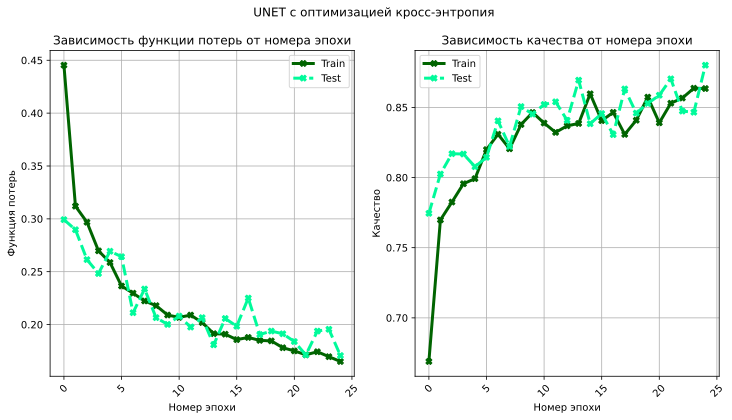

In [ ]:
plot(loss_all, iou_all, loss_test, iou_test, 'кросс-энтропия')

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


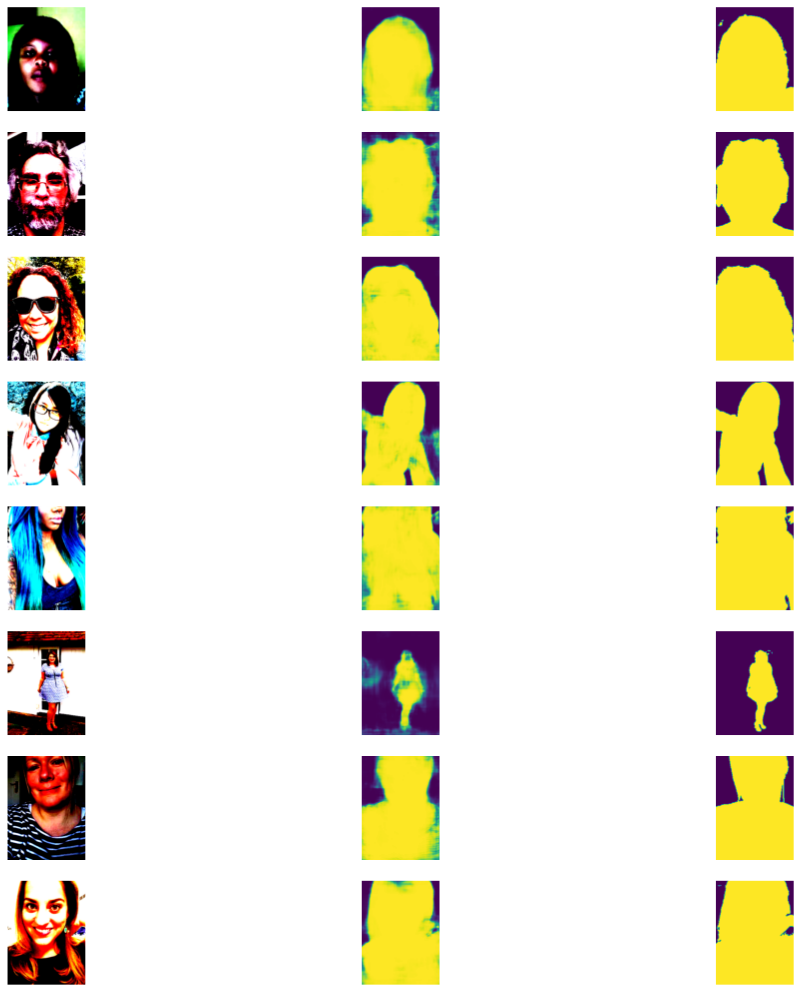

In [ ]:
show_imgs(model, train_data_loader)

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir ../train_UNet_writer

**Только dice loss**

In [ ]:
model = UNet()
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device = torch.device(device)
model.to(device)
model.device = device

num_epoch = 25

loss = DiceLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

In [ ]:
writer = SummaryWriter(log_dir='../train_UNet_writer_DiceLoss')
start = time.time()
writer, loss_all, iou_all, loss_test, iou_test, X_fixed, y_fixed, y_pred = train(model, 
                                                                         train_data_loader, test_data_loader, num_epoch, 
                                                                         loss, optimizer, writer, 'Unet_DiceLoss', True)
print("TIME: ", time.time() - start)
writer.close()

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


0 TRAIN LOSS:  0.2983676435770812 TRAIN IOU:  0.649944802125295 TEST LOSS:  0.19220628848312593 TEST IOU:  0.773986850466047
1 TRAIN LOSS:  0.19622402522299026 TRAIN IOU:  0.7584773909370854 TEST LOSS:  0.169745719707604 TEST IOU:  0.7891423152043269
2 TRAIN LOSS:  0.18776769889725578 TRAIN IOU:  0.7720637537736809 TEST LOSS:  0.16370163562027276 TEST IOU:  0.8059720126065341
3 TRAIN LOSS:  0.18333313977276838 TRAIN IOU:  0.7770466942872319 TEST LOSS:  0.1679237129840445 TEST IOU:  0.8086850245793661
4 TRAIN LOSS:  0.17683477209673987 TRAIN IOU:  0.7878595654246876 TEST LOSS:  0.16010281972005858 TEST IOU:  0.820739037460751
5 TRAIN LOSS:  0.17281315988964505 TRAIN IOU:  0.7830754177023967 TEST LOSS:  0.15502755280504835 TEST IOU:  0.8303511142730713
6 TRAIN LOSS:  0.16627083787211666 TRAIN IOU:  0.8007133952949358 TEST LOSS:  0.1521244427413805 TEST IOU:  0.8376369987215314
7 TRAIN LOSS:  0.16504983573048204 TRAIN IOU:  0.8021308773237726 TEST LOSS:  0.14840412250858673 TEST IOU:  0.8

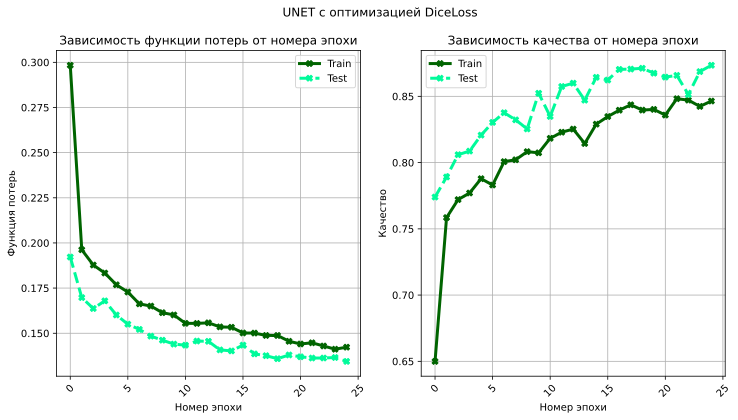

In [ ]:
plot(loss_all, iou_all, loss_test, iou_test, 'DiceLoss')

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


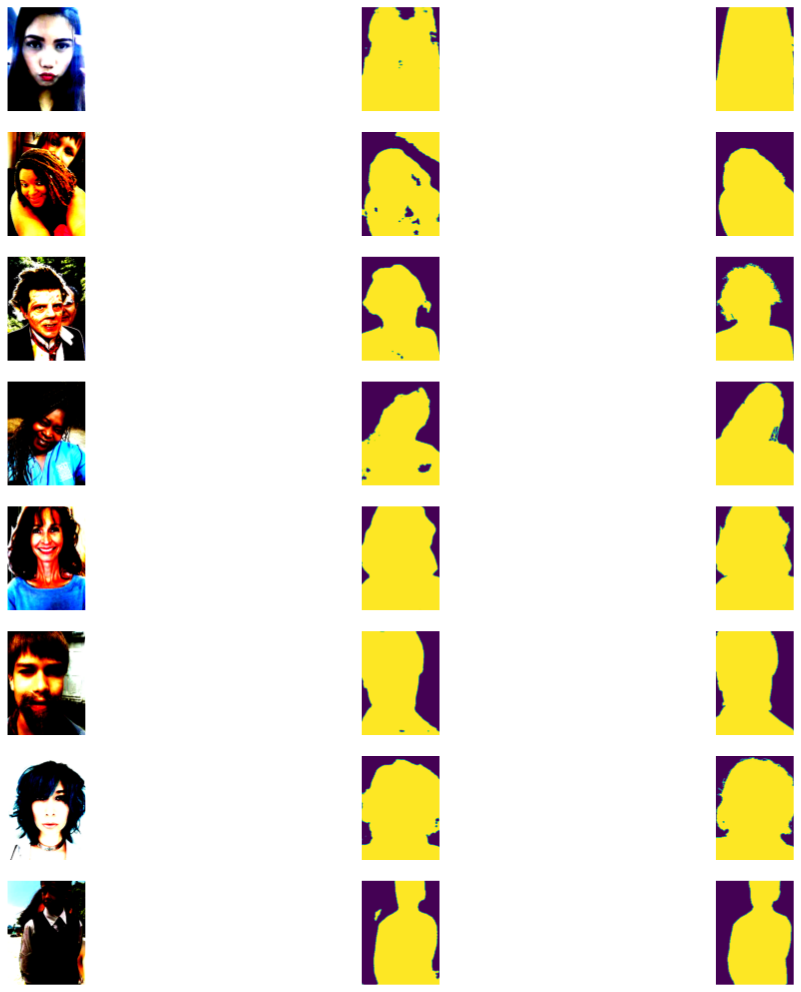

In [ ]:
show_imgs(model, train_data_loader)

**Сумма двух лоссов с весами**

In [ ]:
class loss_sum:
  def __init__(self, w):
    self.w = w
  
  def __call__(self, x1, x2):
    bce = torch.nn.BCEWithLogitsLoss(reduction='mean')
    dice = DiceLoss(reduction='mean')
    return self.w * bce(x1, x2) + (1 - self.w) * dice(x1, x2)

In [ ]:
model = UNet()
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device = torch.device(device)
model.to(device)
model.device = device

num_epoch = 25

loss = loss_sum(0.5)
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

In [ ]:
writer = SummaryWriter(log_dir='../train_UNet_writer_loss_sum_05')
start = time.time()
writer, loss_all, iou_all, loss_test, iou_test, X_fixed, y_fixed, y_pred = train(model, 
                                                                         train_data_loader, test_data_loader, num_epoch, 
                                                                         loss, optimizer, writer, 'Unet_loss_sum_05', True)
print("TIME: ", time.time() - start)
writer.close()

0 TRAIN LOSS:  0.3954808498311926 TRAIN IOU:  0.6809636841649594 TEST LOSS:  0.26267759628752446 TEST IOU:  0.8108395099639892
1 TRAIN LOSS:  0.2760911796711109 TRAIN IOU:  0.770939004726899 TEST LOSS:  0.23980875260441015 TEST IOU:  0.8147370100021363
2 TRAIN LOSS:  0.2620638759047897 TRAIN IOU:  0.780189751804649 TEST LOSS:  0.23361131041607958 TEST IOU:  0.8137161657214165
3 TRAIN LOSS:  0.24509608105376915 TRAIN IOU:  0.7952926264089697 TEST LOSS:  0.21355053919849667 TEST IOU:  0.8217879022870745
4 TRAIN LOSS:  0.23416017415346924 TRAIN IOU:  0.8033110348383585 TEST LOSS:  0.22441814364270962 TEST IOU:  0.8276774168014527
5 TRAIN LOSS:  0.22113859874230843 TRAIN IOU:  0.8137537026405335 TEST LOSS:  0.19156844163617343 TEST IOU:  0.8574725786844889
6 TRAIN LOSS:  0.2164391021375303 TRAIN IOU:  0.812277898496511 TEST LOSS:  0.20306452284467982 TEST IOU:  0.8488023430109024
7 TRAIN LOSS:  0.20758256667190128 TRAIN IOU:  0.8291744676729044 TEST LOSS:  0.1942893368132571 TEST IOU:  0.8

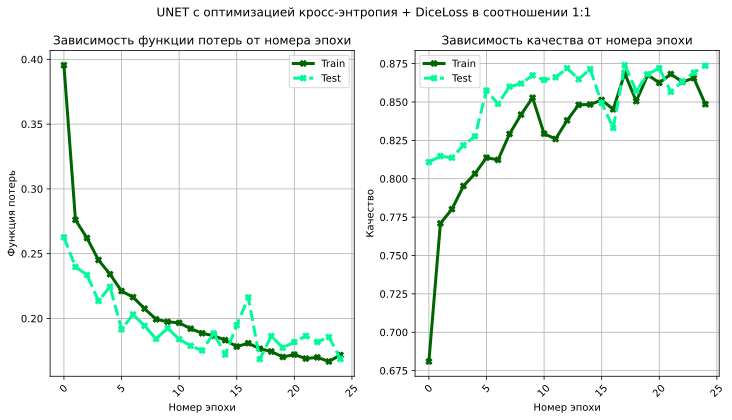

In [ ]:
plot(loss_all, iou_all, loss_test, iou_test, 'кросс-энтропия + DiceLoss в соотношении 1:1')

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


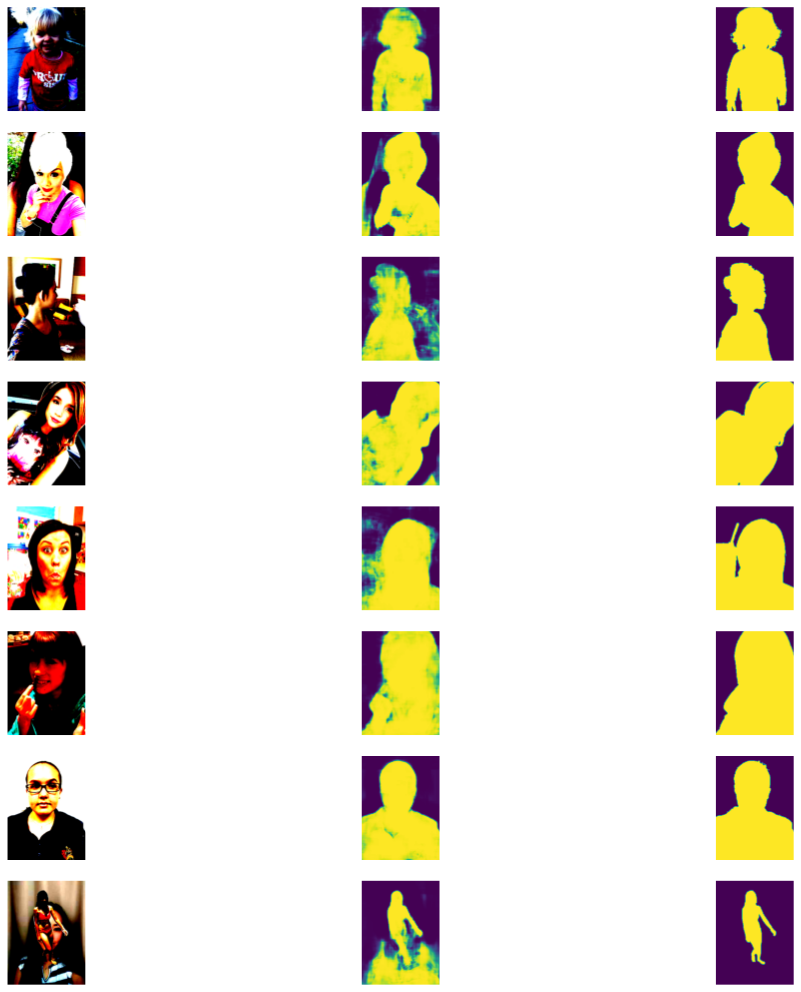

In [ ]:
show_imgs(model, train_data_loader)

1:4

In [ ]:
model = UNet()
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device = torch.device(device)
model.to(device)
model.device = device

num_epoch = 25

loss = loss_sum(0.2)
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

In [ ]:
writer = SummaryWriter(log_dir='../train_UNet_writer_loss_sum_02')
start = time.time()
writer, loss_all, iou_all, loss_test, iou_test, X_fixed, y_fixed, y_pred = train(model, 
                                                                         train_data_loader, test_data_loader, num_epoch, 
                                                                         loss, optimizer, writer, 'Unet_loss_sum_02', True)
print("TIME: ", time.time() - start)
writer.close()

0 TRAIN LOSS:  0.34097459656220896 TRAIN IOU:  0.6716229053305798 TEST LOSS:  0.24300485268129524 TEST IOU:  0.7960679729779562
1 TRAIN LOSS:  0.24253547591191751 TRAIN IOU:  0.775989289516988 TEST LOSS:  0.2065923883982584 TEST IOU:  0.7996455381313959
2 TRAIN LOSS:  0.22688408343880265 TRAIN IOU:  0.7825426210959753 TEST LOSS:  0.20665965477625528 TEST IOU:  0.7956728935241699
3 TRAIN LOSS:  0.2198026090860367 TRAIN IOU:  0.7867492488943614 TEST LOSS:  0.18774090485369904 TEST IOU:  0.8222769995530447
4 TRAIN LOSS:  0.21069258424970838 TRAIN IOU:  0.8022837005163493 TEST LOSS:  0.17839657245798313 TEST IOU:  0.8226660589377085
5 TRAIN LOSS:  0.20332608770441127 TRAIN IOU:  0.8092931480968699 TEST LOSS:  0.19360182471309148 TEST IOU:  0.844297836224238
6 TRAIN LOSS:  0.19591432553750499 TRAIN IOU:  0.8153859578511294 TEST LOSS:  0.17874478258139698 TEST IOU:  0.850608229637146
7 TRAIN LOSS:  0.1935647028905374 TRAIN IOU:  0.8198899761551902 TEST LOSS:  0.1768861912877847 TEST IOU:  0.

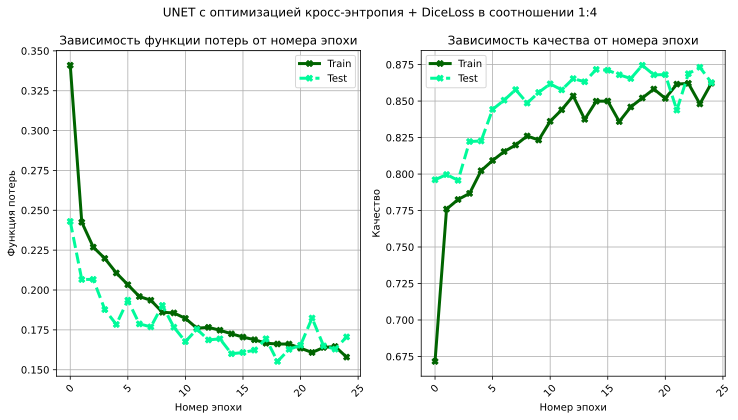

In [ ]:
plot(loss_all, iou_all, loss_test, iou_test, 'кросс-энтропия + DiceLoss в соотношении 1:4')

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


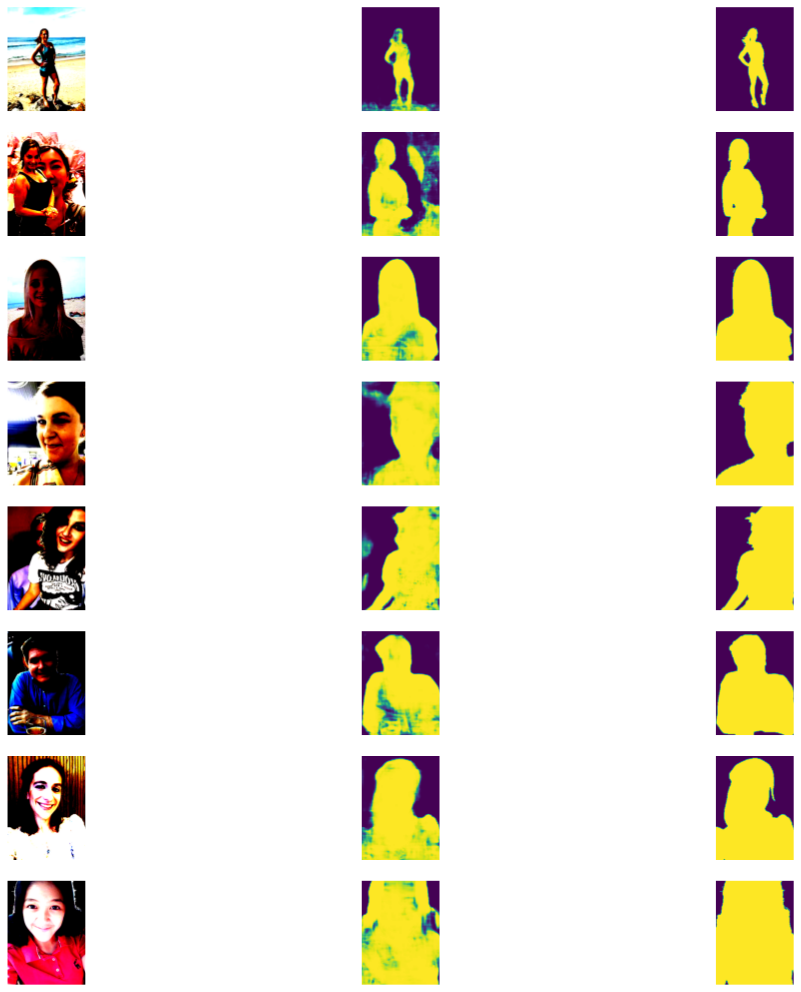

In [ ]:
show_imgs(model, train_data_loader)

4:1

In [ ]:
model = UNet()
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device = torch.device(device)
model.to(device)
model.device = device

num_epoch = 25

loss = loss_sum(0.8)
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

In [ ]:
writer = SummaryWriter(log_dir='../train_UNet_writer_loss_sum_08')
start = time.time()
writer, loss_all, iou_all, loss_test, iou_test, X_fixed, y_fixed, y_pred = train(model, 
                                                                         train_data_loader, test_data_loader, num_epoch, 
                                                                         loss, optimizer, writer, 'Unet_loss_sum_08', True)
print("TIME: ", time.time() - start)
writer.close()

0 TRAIN LOSS:  0.42828308957594413 TRAIN IOU:  0.6640390014648437 TEST LOSS:  0.27391505030030056 TEST IOU:  0.8085430860519409
1 TRAIN LOSS:  0.30436940634692156 TRAIN IOU:  0.7851758293616466 TEST LOSS:  0.24633887262209087 TEST IOU:  0.8333948403596878
2 TRAIN LOSS:  0.2867288878228929 TRAIN IOU:  0.78078995328961 TEST LOSS:  0.24565324652279522 TEST IOU:  0.8249905407428741
3 TRAIN LOSS:  0.26485377289630746 TRAIN IOU:  0.7814060326606508 TEST LOSS:  0.25844955106153555 TEST IOU:  0.81465283036232
4 TRAIN LOSS:  0.24436432414584688 TRAIN IOU:  0.8011206047875541 TEST LOSS:  0.2255109338261557 TEST IOU:  0.8456844389438629
5 TRAIN LOSS:  0.2267786931770819 TRAIN IOU:  0.829614656312125 TEST LOSS:  0.21403423247607886 TEST IOU:  0.8491968810558319
6 TRAIN LOSS:  0.22340483484444795 TRAIN IOU:  0.8378793533359256 TEST LOSS:  0.20127871548030393 TEST IOU:  0.8564730882644653
7 TRAIN LOSS:  0.21761498506422397 TRAIN IOU:  0.8327088301832025 TEST LOSS:  0.198798490859938 TEST IOU:  0.852

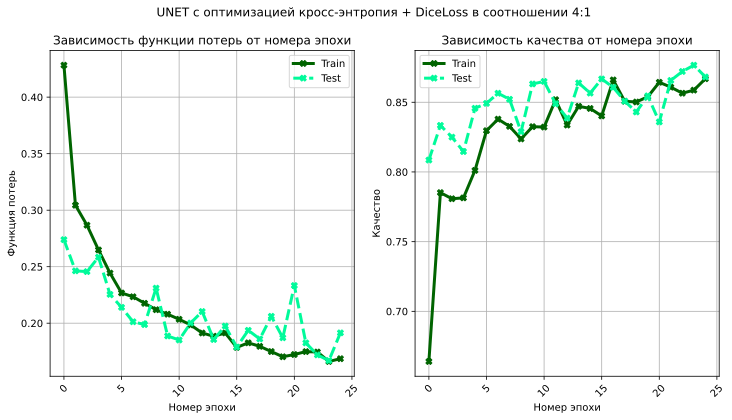

In [ ]:
plot(loss_all, iou_all, loss_test, iou_test, 'кросс-энтропия + DiceLoss в соотношении 4:1')

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


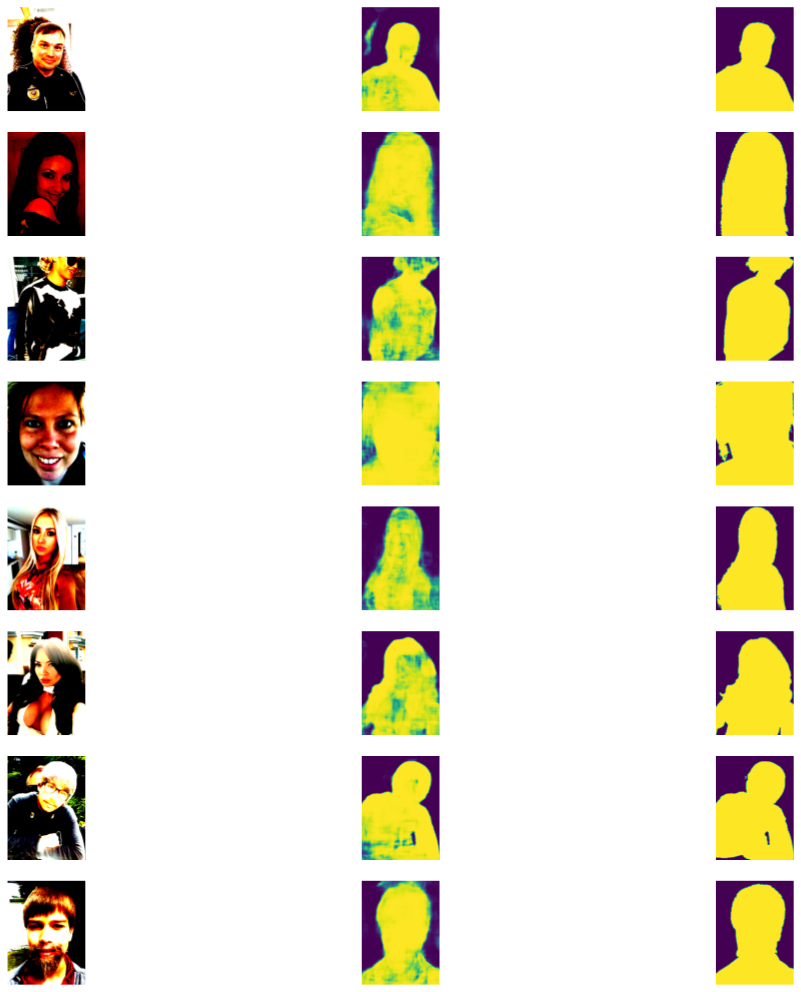

In [ ]:
show_imgs(model, train_data_loader)

**ВЫВОДЫ**
1. Только кросс-энтропия

Время обучения 38,5 минут. Важно отметить, что по какой-то причине в колабе первая эпоха первого эксперимента идет оочень долго, добрые одногруппники сказали, что дело в кэшировании.
Контуры распознаны достаточно хорошо, но есть существенный шум вне контура. Функция потерь на трейне ведет себя устойчиво и стабильно снижается, достигая значения 0,16 на последней эпохе. Функции качества и потерь на тесте ведут себя неустойчиво, но в целом наблюдается тенденция повышения качества/снижения потерь. На тесте достигается значение функции потерь 0,17, качество на трейне 0,86, на тесте 0,88. Заметим, что потери и качество тест, как правило, не хуже трейна, хотя интуитивно кажется, что должно быть наоборот. Это наблюдается и в других экспериментах. Это скорее всего связано с тем, что на трейне проводятся случайные преобразования изображений и это ухудшает результат модели, особенно в случае замены заднего фона на другого четко видного человека.

2. Только dice loss

 Время обучения 37,6 минут. Функция потерь ведет себя стабильно и снижается без скачков, функция качества для теста немного неустойчива, но намного лучше, чем в случае кросс-энтропии. На трейне достигается значение функции потерь 0,141, на тесте 0,134, качество на трейне (лучшее) 0,848, на тесте 0,873. Значения функции потерь лучше, чем при кросс-энтропии, а качество наоборот хуже. При данной функции потерь качество на тесте стабильно выше, а функция потерь на тесте стабильно ниже. Выше была объяснена причина, по которой это предположительно происходит, заметим, что маски для изображений на трейне это подтверждают. У результата модели нет таких шумов, как в кросс-энтропии, и в случае, если нет явно заметных преобразований изображения (см последние две картинки), модель распознает маски очень хорошо. Есть "пустоты" внутри контура, причем не в виде шума, а прям такие уверенные. Но если изображение затемнено и особенно если есть задний фон, распознавание становится намного хуже. На тесте же нет никаких преобразований.
 
3. Сумма двух лоссов с весами 

Рассматриваются следующие варианты:

1) кросс-энтропия:dice loss = 1:1

2) кросс-энтропия:dice loss = 1:4

3) кросс-энтропия:dice loss = 4:1

Общие выводы: чем больше вес кросс-энтропии, тем более нестабильно ведут себя функции потерь и качества на тесте. Время обучения отличается незначительно от предыдущих двух пунктов, функция потерь достигает значений ниже, чем кросс-энтропия, но ниже, чем diceloss, качество наоборот. Улучшения, возможно, заметны только с самими изображениями: у них значительно меньше "шумов", чем у кросс-энтропии за контуром, пустоты внутри контуров, которые были у diceloss,  стали как в виде шума.

## `LinkNet (2 балла)`

Реализуйте архитектуру [LinkNet](https://arxiv.org/pdf/1707.03718.pdf) с использованием энкодера, основанного на `VGG13`. Архитектура похожа на `Unet`, но вместо конкатенации слоёв используются skip-connections. Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

**Обучите сеть и проведите анализ согласно предыдущему пункту. Сравните LinkNet и U-Net по качеству и скорости работы. Сделайте выводы.**

In [83]:
# your code here
class DecoderBlockLinkNet(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = torch.nn.ReLU()
        
    def forward(self, down, left):
        # Upsample x2 и свёртка
        # your code here
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        
        # Конкатенация выхода энкодера и предыдущего блока декодера
        # your code here
        x = self.upconv(x)
        
        # Две свёртки с ReLu
        # your code here
        x = self.conv2(self.conv1(x + left))

        return x


class DecoderLinkNet(torch.nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        self.blocks = torch.nn.ModuleList()
        for idx in range(num_blocks):
            self.blocks.insert(0, DecoderBlockLinkNet(num_filters * 2 ** idx))

    def forward(self, acts):
        up = acts[-1]
        for block, left in zip(self.blocks, acts[-2::-1]):
            up = block(up, left)
        return up


class LinkNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_blocks=4):
        super().__init__()
        # your code here
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        
        # your code here
        self.decoder = DecoderLinkNet(num_filters=64, num_blocks=num_blocks-1)
        
        # Свёртка 1x1 для попиксельной агрегации каналов
        # your code here
        self.final = torch.nn.Conv2d(
            in_channels=64,
            out_channels=num_classes,
            kernel_size=1)

    def forward(self, x):
        # your code here
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.final(x)

        return x

In [84]:
def plot(loss_all, iou_all, loss_test, iou_test, s):
  plt.figure(figsize=(12, 6))
  plt.suptitle("LinkNet с оптимизацией " + s)
  plt.subplot(1, 2, 1)
  plt.title("Зависимость функции потерь от номера эпохи")
  plt.plot(list(range(len(loss_all))), loss_all, marker='X', color='darkgreen', label='Train', linewidth=3)
  plt.plot(list(range(len(loss_test))), loss_test, marker='X', color='mediumspringgreen', label='Test', linestyle='--', linewidth=3)
  plt.xlabel('Номер эпохи')
  plt.ylabel('Функция потерь')
  plt.xticks(rotation=45)
  plt.grid()
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.title("Зависимость качества от номера эпохи")
  plt.plot(list(range(len(iou_all))), iou_all, marker='X', color='darkgreen', label='Train', linewidth=3)
  plt.plot(list(range(len(iou_test))), iou_test, marker='X', color='mediumspringgreen', label='Test', linestyle='--', linewidth=3)
  plt.xlabel('Номер эпохи')
  plt.ylabel('Качество')
  plt.xticks(rotation=45)
  plt.grid()
  plt.legend()

  plt.show()

In [85]:
model = LinkNet()
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device = torch.device(device)
model.to(device)
model.device = device
num_epoch = 25
loss = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

In [86]:
import time

writer = SummaryWriter(log_dir='../train_LinkNet_writer_BCEWithLogitsLoss')
start = time.time()
writer, loss_all, iou_all, loss_test, iou_test, X_fixed, y_fixed, y_pred = train(model, 
                                                                         train_data_loader, test_data_loader, num_epoch, 
                                                                         loss, optimizer, writer, 'LinkNet_BCEWithLogitsLoss', True)
print("TIME: ", time.time() - start)
writer.close()

0 TRAIN LOSS:  0.4409647298300708 TRAIN IOU:  0.6619462319215139 TEST LOSS:  0.2892399567661556 TEST IOU:  0.7825787961483002
1 TRAIN LOSS:  0.31849528590838116 TRAIN IOU:  0.7826729387771793 TEST LOSS:  0.2807626631243009 TEST IOU:  0.7834001580874125
2 TRAIN LOSS:  0.3001188995220043 TRAIN IOU:  0.7738999958131828 TEST LOSS:  0.26763177298484964 TEST IOU:  0.7975621819496155
3 TRAIN LOSS:  0.2724556429297836 TRAIN IOU:  0.7941580668824618 TEST LOSS:  0.2594486459138546 TEST IOU:  0.812777449687322
4 TRAIN LOSS:  0.2522225668253722 TRAIN IOU:  0.8111897362603082 TEST LOSS:  0.264577476268119 TEST IOU:  0.7927278677622477
5 TRAIN LOSS:  0.24501637547104446 TRAIN IOU:  0.8120181350147023 TEST LOSS:  0.24926064728845096 TEST IOU:  0.8109598755836487
6 TRAIN LOSS:  0.2393615209835547 TRAIN IOU:  0.8093705773353577 TEST LOSS:  0.25708413631358046 TEST IOU:  0.8188766241073608
7 TRAIN LOSS:  0.22841742930588899 TRAIN IOU:  0.802811754472328 TEST LOSS:  0.20979051143987804 TEST IOU:  0.85094

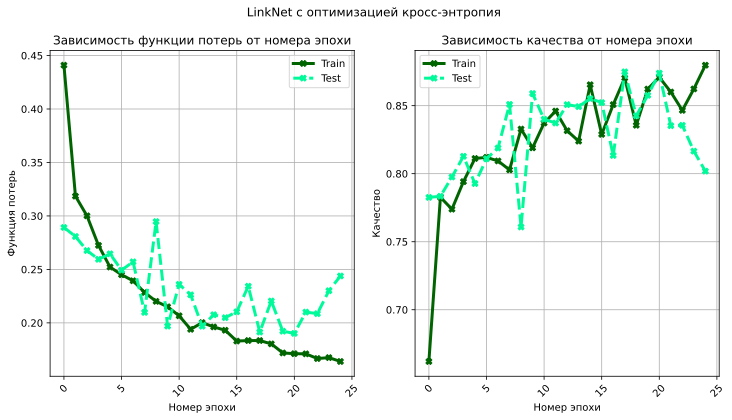

In [87]:
plot(loss_all, iou_all, loss_test, iou_test, 'кросс-энтропия')

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


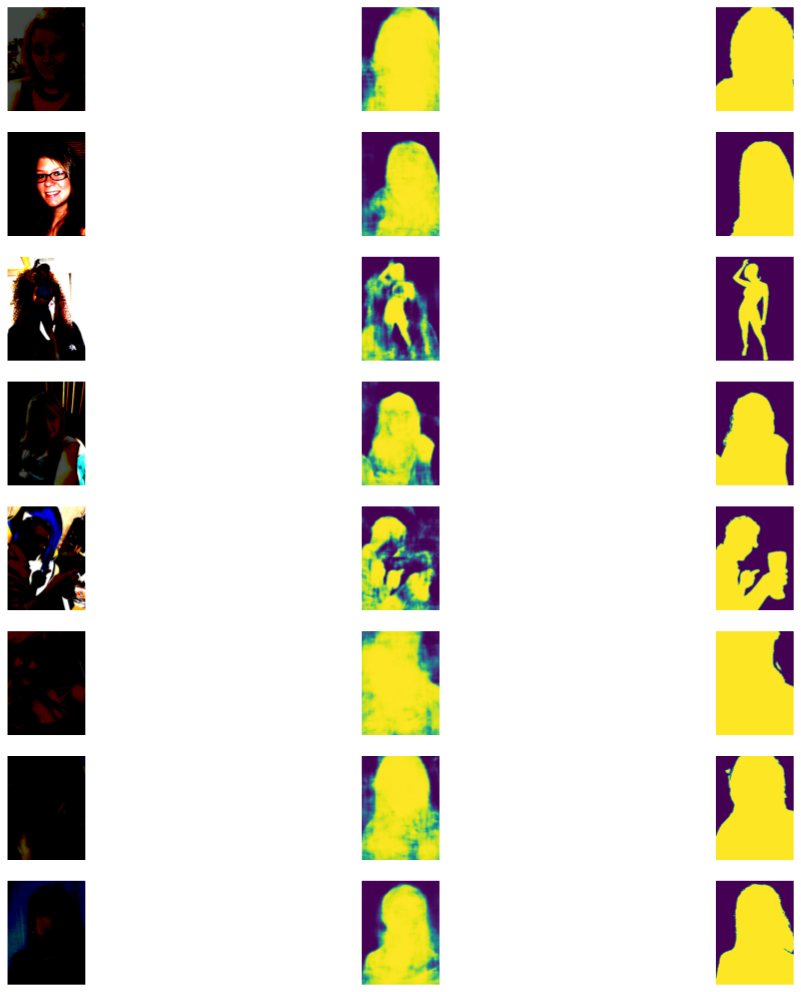

In [88]:
show_imgs(model, train_data_loader)

**Diceloss**

In [89]:
model = LinkNet()
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device = torch.device(device)
model.to(device)
model.device = device
num_epoch = 25
loss = DiceLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

In [90]:
writer = SummaryWriter(log_dir='../train_LinkNet_writer_DiceLoss')
start = time.time()
writer, loss_all, iou_all, loss_test, iou_test, X_fixed, y_fixed, y_pred = train(model, 
                                                                         train_data_loader, test_data_loader, num_epoch, 
                                                                         loss, optimizer, writer, 'LinkNet_DiceLoss', True)
print("TIME: ", time.time() - start)
writer.close()

0 TRAIN LOSS:  0.28516064480498987 TRAIN IOU:  0.6596973629353883 TEST LOSS:  0.18521792954164193 TEST IOU:  0.7777389458247593
1 TRAIN LOSS:  0.19770674387613932 TRAIN IOU:  0.7666437660606162 TEST LOSS:  0.1687547526461013 TEST IOU:  0.7903255928646434
2 TRAIN LOSS:  0.18602208562471248 TRAIN IOU:  0.7743358176063608 TEST LOSS:  0.16443170321748612 TEST IOU:  0.8071376502513885
3 TRAIN LOSS:  0.17853346036540138 TRAIN IOU:  0.7877060558933479 TEST LOSS:  0.16170467954155401 TEST IOU:  0.8121599952379862
4 TRAIN LOSS:  0.17757035434246063 TRAIN IOU:  0.7895458048465205 TEST LOSS:  0.15582764201553156 TEST IOU:  0.8084290275971094
5 TRAIN LOSS:  0.1724071298153312 TRAIN IOU:  0.7988071618853388 TEST LOSS:  0.15577996685995277 TEST IOU:  0.8207319047715929
6 TRAIN LOSS:  0.17128847420215607 TRAIN IOU:  0.79400610603312 TEST LOSS:  0.15202795180445866 TEST IOU:  0.8206492987546053
7 TRAIN LOSS:  0.16771344206951283 TRAIN IOU:  0.8070478638013204 TEST LOSS:  0.15465399284734793 TEST IOU: 

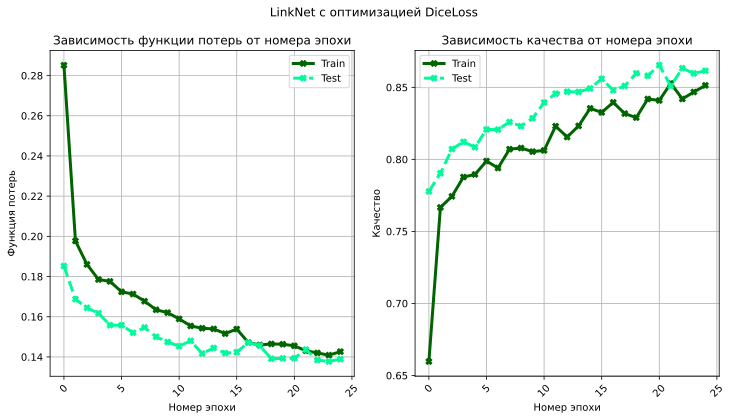

In [91]:
plot(loss_all, iou_all, loss_test, iou_test, 'DiceLoss')

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


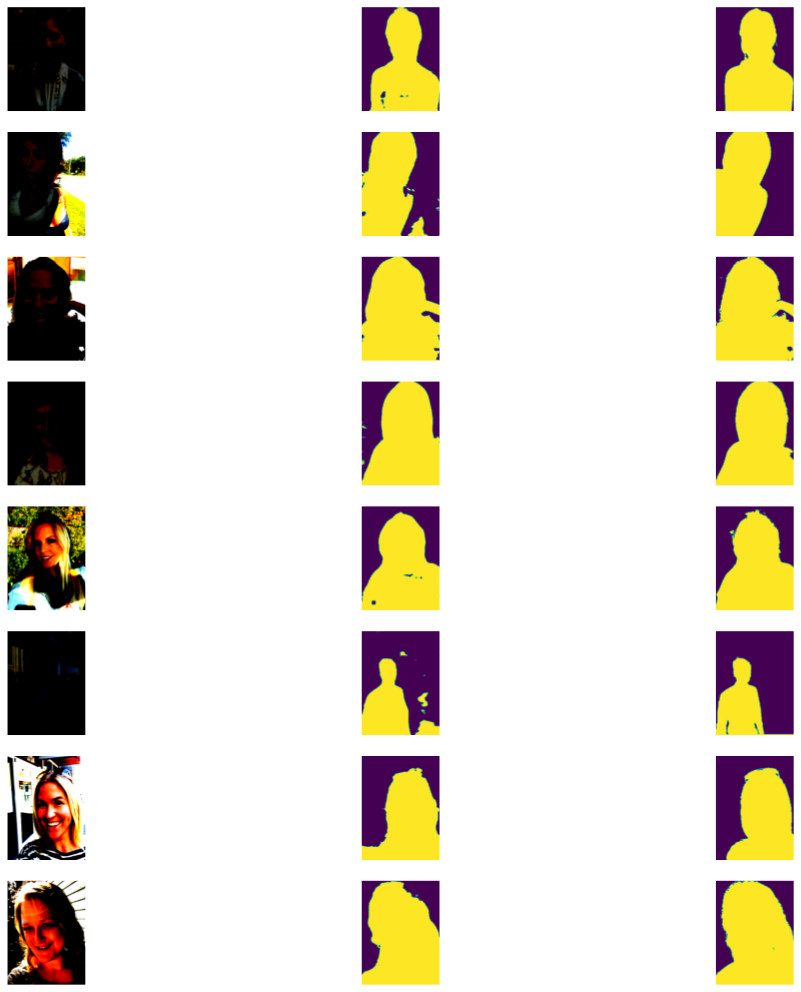

In [92]:
show_imgs(model, train_data_loader)

**С весами 1:1**

In [93]:
# тот же класс, что и был, просто страшно что-то компилировать в разделе Unet
class loss_sum:
  def __init__(self, w):
    self.w = w
  
  def __call__(self, x1, x2):
    bce = torch.nn.BCEWithLogitsLoss(reduction='mean')
    dice = DiceLoss(reduction='mean')
    return self.w * bce(x1, x2) + (1 - self.w) * dice(x1, x2)

In [94]:
model = LinkNet()
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device = torch.device(device)
model.to(device)
model.device = device

num_epoch = 25

loss = loss_sum(0.5)
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

In [95]:
writer = SummaryWriter(log_dir='../train_LinkNet_writer_loss_sum_05')
start = time.time()
writer, loss_all, iou_all, loss_test, iou_test, X_fixed, y_fixed, y_pred = train(model, 
                                                                         train_data_loader, test_data_loader, num_epoch, 
                                                                         loss, optimizer, writer, 'LinkNet_loss_sum_05', True)
print("TIME: ", time.time() - start)
writer.close()

0 TRAIN LOSS:  0.37985299980198894 TRAIN IOU:  0.6935130189923406 TEST LOSS:  0.25633641633581605 TEST IOU:  0.7799761295318604
1 TRAIN LOSS:  0.2803316998481751 TRAIN IOU:  0.7769056847319007 TEST LOSS:  0.24094575558993833 TEST IOU:  0.79757359623909
2 TRAIN LOSS:  0.25570977833535935 TRAIN IOU:  0.778232682367851 TEST LOSS:  0.24239895265575842 TEST IOU:  0.8030637332371303
3 TRAIN LOSS:  0.24130182915263707 TRAIN IOU:  0.8039878675903099 TEST LOSS:  0.21956359346707663 TEST IOU:  0.8217612845557076
4 TRAIN LOSS:  0.23298989529962894 TRAIN IOU:  0.8069238730015293 TEST LOSS:  0.22254250943660736 TEST IOU:  0.8275727272033692
5 TRAIN LOSS:  0.22576001785419605 TRAIN IOU:  0.8009763595669769 TEST LOSS:  0.20761005400765872 TEST IOU:  0.8328314423561096
6 TRAIN LOSS:  0.22264004839791193 TRAIN IOU:  0.807766318321228 TEST LOSS:  0.2111481193532335 TEST IOU:  0.8310466527938842
7 TRAIN LOSS:  0.2063688634943079 TRAIN IOU:  0.8206659740871853 TEST LOSS:  0.21202959025159795 TEST IOU:  0.

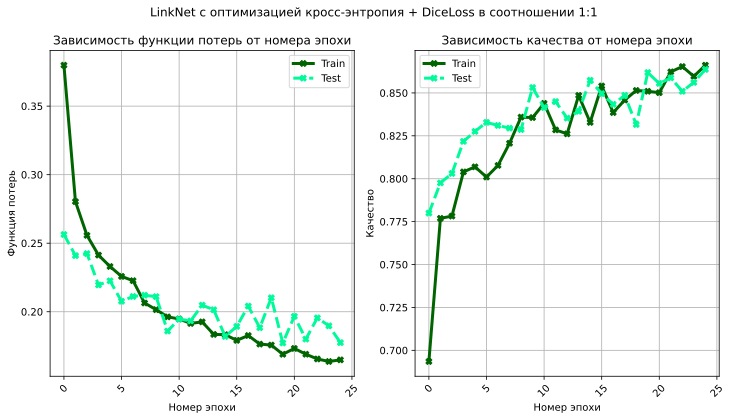

In [96]:
plot(loss_all, iou_all, loss_test, iou_test, 'кросс-энтропия + DiceLoss в соотношении 1:1')

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


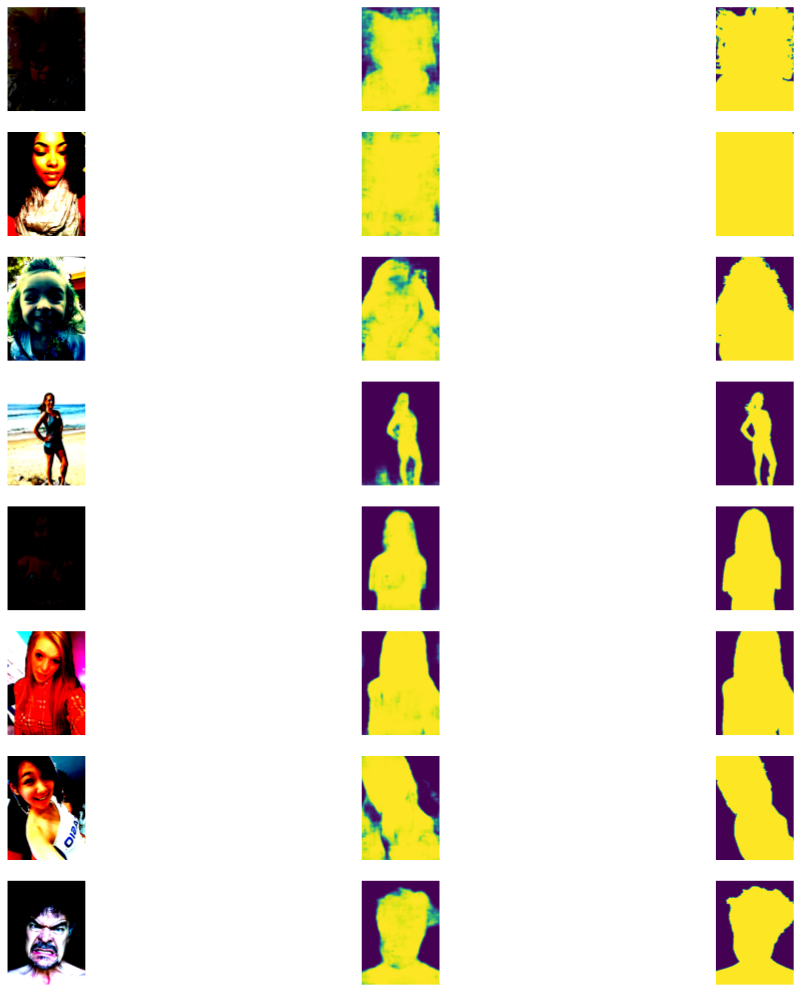

In [97]:
show_imgs(model, train_data_loader)

1:4

In [98]:
model = LinkNet()
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device = torch.device(device)
model.to(device)
model.device = device

num_epoch = 25

loss = loss_sum(0.2)
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

In [99]:
writer = SummaryWriter(log_dir='../train_LinkNet_writer_loss_sum_02')
start = time.time()
writer, loss_all, iou_all, loss_test, iou_test, X_fixed, y_fixed, y_pred = train(model, 
                                                                         train_data_loader, test_data_loader, num_epoch, 
                                                                         loss, optimizer, writer, 'LinkNet_loss_sum_02', True)
print("TIME: ", time.time() - start)
writer.close()

0 TRAIN LOSS:  0.3389940611521403 TRAIN IOU:  0.6620380366132372 TEST LOSS:  0.22544693428996607 TEST IOU:  0.7887908021608988
1 TRAIN LOSS:  0.24490110101523221 TRAIN IOU:  0.7777914664324592 TEST LOSS:  0.20975452703787079 TEST IOU:  0.7895220816135406
2 TRAIN LOSS:  0.23324443640532316 TRAIN IOU:  0.7768739638942304 TEST LOSS:  0.2042315015767483 TEST IOU:  0.8073437430641868
3 TRAIN LOSS:  0.21921958733488012 TRAIN IOU:  0.7938862061500549 TEST LOSS:  0.20061042968263018 TEST IOU:  0.8073809693257014
4 TRAIN LOSS:  0.21191574814143005 TRAIN IOU:  0.8030415195049626 TEST LOSS:  0.19319996914119586 TEST IOU:  0.8068994191976694
5 TRAIN LOSS:  0.20214710014837758 TRAIN IOU:  0.8065031352250472 TEST LOSS:  0.19444426608846543 TEST IOU:  0.8187984095679389
6 TRAIN LOSS:  0.19884116954273648 TRAIN IOU:  0.8169012428858341 TEST LOSS:  0.1803320068205502 TEST IOU:  0.8407689705491066
7 TRAIN LOSS:  0.1910070460593259 TRAIN IOU:  0.8193969021380787 TEST LOSS:  0.1881110520227581 TEST IOU:  

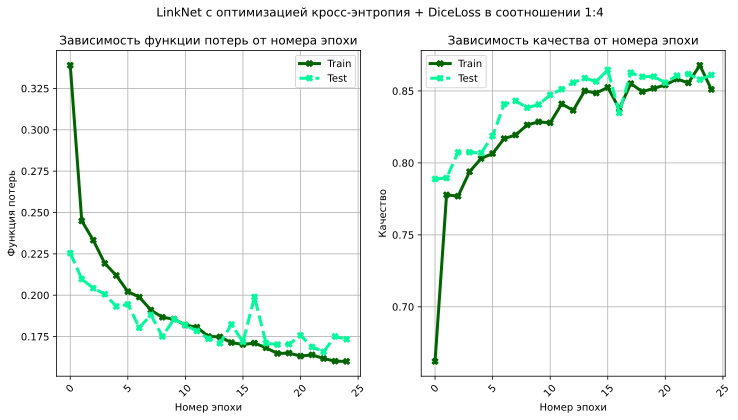

In [100]:
plot(loss_all, iou_all, loss_test, iou_test, 'кросс-энтропия + DiceLoss в соотношении 1:4')

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


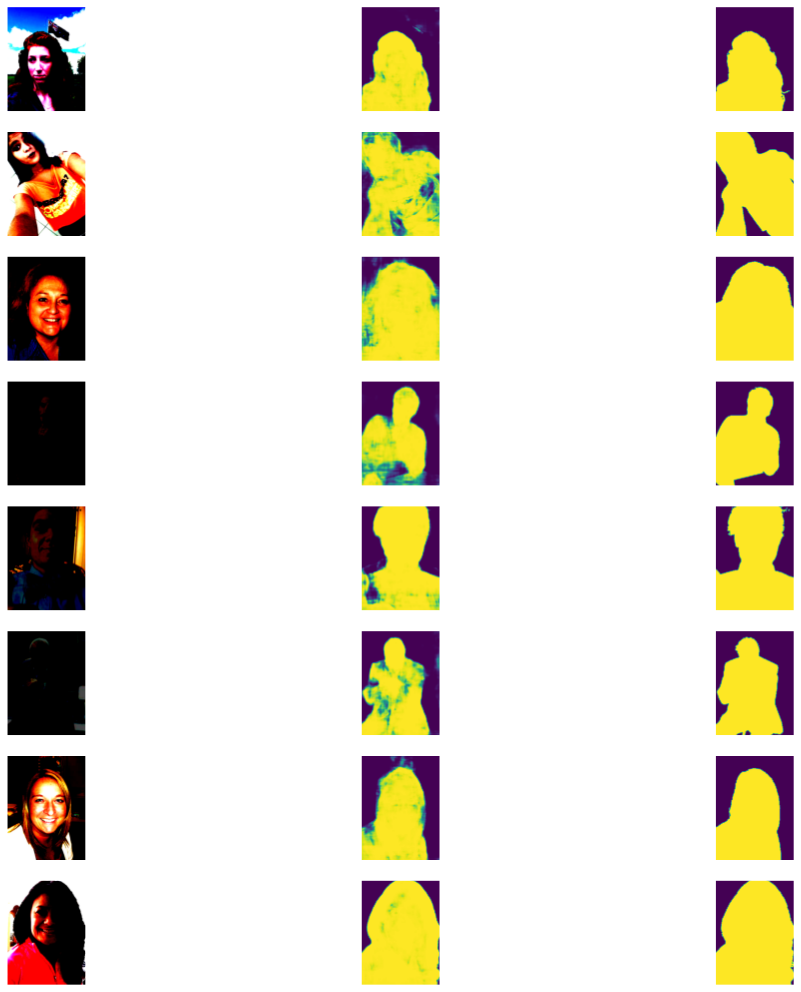

In [101]:
show_imgs(model, train_data_loader)

4:1

In [102]:
model = LinkNet()
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device = torch.device(device)
model.to(device)
model.device = device

num_epoch = 25

loss = loss_sum(0.8)
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

In [103]:
writer = SummaryWriter(log_dir='../train_LinkNet_writer_loss_sum_08')
start = time.time()
writer, loss_all, iou_all, loss_test, iou_test, X_fixed, y_fixed, y_pred = train(model, 
                                                                         train_data_loader, test_data_loader, num_epoch, 
                                                                         loss, optimizer, writer, 'LinkNet_loss_sum_08', True)
print("TIME: ", time.time() - start)
writer.close()

0 TRAIN LOSS:  0.420570901411551 TRAIN IOU:  0.6668752548171253 TEST LOSS:  0.28271759887959097 TEST IOU:  0.7826118618249893
1 TRAIN LOSS:  0.308777481979794 TRAIN IOU:  0.7707157492637634 TEST LOSS:  0.26607205808585416 TEST IOU:  0.7947506209214529
2 TRAIN LOSS:  0.27417978931356357 TRAIN IOU:  0.7809878493610182 TEST LOSS:  0.25038048159991594 TEST IOU:  0.8062761425971985
3 TRAIN LOSS:  0.2597747023458834 TRAIN IOU:  0.7958602929115295 TEST LOSS:  0.24038275188588082 TEST IOU:  0.8119660139083862
4 TRAIN LOSS:  0.24426097556396767 TRAIN IOU:  0.8015974273487013 TEST LOSS:  0.25704739808190796 TEST IOU:  0.8090728670358658
5 TRAIN LOSS:  0.23716495246798905 TRAIN IOU:  0.8073432800617624 TEST LOSS:  0.22977731900012238 TEST IOU:  0.8268615454435349
6 TRAIN LOSS:  0.2259024883861895 TRAIN IOU:  0.8092059699388651 TEST LOSS:  0.2229736736902954 TEST IOU:  0.8325684517621994
7 TRAIN LOSS:  0.21595209969414605 TRAIN IOU:  0.8322495426982641 TEST LOSS:  0.23926425910165125 TEST IOU:  0.

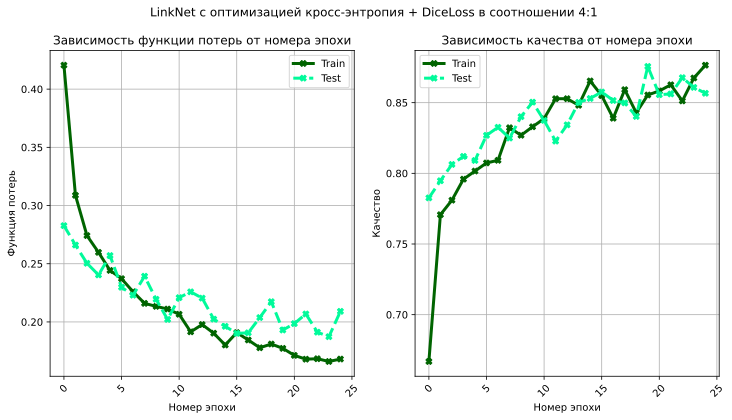

In [104]:
plot(loss_all, iou_all, loss_test, iou_test, 'кросс-энтропия + DiceLoss в соотношении 4:1')

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


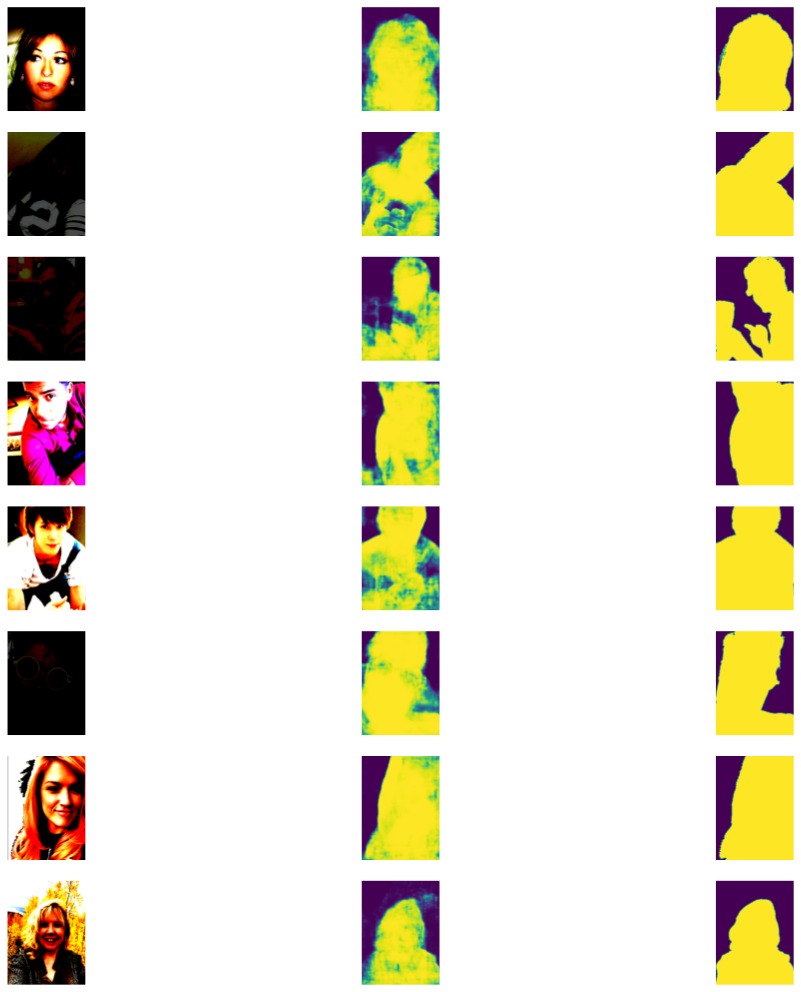

In [105]:
show_imgs(model, train_data_loader)

**ВЫВОДЫ**
1. Только кросс-энтропия

Время обучения 41,5 минут. Функция потерь на трейне стабильно снижается и достигает значения 0,16, качество на трейне ведет себя нестабильно (в отличие от unet), но в целом заметна тенденция повышения и достигается значение 0,88. На тесте вообще непонятно что происходит, функция и потерь, и качества ведет себя крайне нестабильно, а после 20 эпохи все ухудшается. Лучшее качество на тесте 0,87, функция потерь 0,19, и то, и другое хуже, чем в unet. Если посмотреть на картинки, заметно, что сами контуры стали менее четкими, чем в unet.

2. Только dice loss

Время обучения 35,4 минут. Функции потерь и качества ведут себя достаточно стабильно, но на трейне качество немного менее стабильно, чем с unet. Лучшее значение функции потерь: 0,141 на трейне, 0,137 на тесте; качество: 0,85 на трейне, 0,865 на тесте. Результаты по качеству похожи на полученные в unet, полученные контуры тоже и ошибки в целом такие же, но при этом время обучения быстрее на 2 минуты.
 
3. Сумма двух лоссов с весами 

Рассматриваются следующие варианты:

1) кросс-энтропия:dice loss = 1:1

2) кросс-энтропия:dice loss = 1:4

3) кросс-энтропия:dice loss = 4:1

Результаты похожи на unet, даже добавить нечего, кроме того, что внутренность контура получается менее четкой. На всякий случай скопирую что было в unet:

Общие выводы: чем больше вес кросс-энтропии, тем более нестабильно ведут себя функции потерь и качества на тесте. Время обучения отличается незначительно от предыдущих двух пунктов, функция потерь достигает значений ниже, чем кросс-энтропия, но ниже, чем diceloss, качество наоборот. Улучшения, возможно, заметны только с самими изображениями: у них значительно меньше "шумов", чем у кросс-энтропии за контуром, пустоты внутри контуров, которые были у diceloss,  стали как в виде шума.

Помимо этого, время обучения быстрее на ~2 минуты, чем unet.


**В целом,** лучшие качество и функции потерь получаются примерно такими же, как в unet, но ведут себя менее стабильно (особенно кросс-энтропия для теста), а время обучения при этом меньше.

## `Теоретические вопросы (1 балл)`

### `Вопрос 1`
* Сформулируйте два предположения о структуре входных данных, на которые опирается архитектура свёрточных сетей. 
* Какие преимущества дает использование сверток в случае, если эти предположения верные? 
* Приведите пример входных данных, когда эти предположения не выполняются.

Предположения:

1. Принцип общих черт – locality. Предполагается компактность интересующих нас в задаче объектов, то есть, в случае изображений, пиксели интересующего объекта расположены близко друг к другу.

2. Наличие определенной структуры во входных данных. Предполагается, что интересующий нас в задаче объект имеет определенную форму, однообразную структуру.

Наличие этих предподоложений позволяет сверткам быстрее и эффективнее обучаться, создать нейронную сеть не больших размеров, то есть уменьшить количество обучаемых параметров  по сравнению с полносвязной нейронной сетью, и получить устойчивость к сдвигу позиции объекта во входных данных.

Примером, когда это не выполняется, в случае рассматриваемой ранее задачи может быть картинка, у которой контур каким-то образом не составляет единый целый объект, а рассредоточен по площади изображения, нечеткая размытая картинка с нечетким контуром (например, человек с очень пышными кудрявыми разбросанными волосами).

### `Вопрос 2`
Пусть дано множество 1-D входов ${x^{(i)} \in \mathbb{R}^{100}}$. 

Рассмотрим полносвязный слой ${f(\cdot)}$, заданный как ${f(x^{(i)}) = \sigma(Wx^{(i)})}$, где ${W}$ - матрица весов размерности ${1000\times 100}$ и ${\sigma(\cdot)}$ поэлементая функция активации. 

Рассмотрим также сверточный слой ${g(\cdot)}$ с десятью картами признаков: ${g(x^{(i)}) = \sigma([z_1, z_2,...,z_{10}])}$, где ${z_j = x^{(i)}\ast w_j}$ для некоторого ядра свертки ${w_j}$ с размером 3 и паддингом 1. Для ${f(\cdot)}$ и ${g(\cdot)}$ напишите: 

1. Размерность выходного пространства. 
2. Количество обучаемых параметров. 
3. Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).

**${f(\cdot)}$**
1. Размерность выходного пространства: 1000 $\times$ 1
2. Количество обучаемых параметров: 1000 * 100 = 100 000
3. Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).

Умножений: 1000 * 100 * 1 = 100 000

Сложений: 1000 * (100 - 1) * 1 = 99 000

Применений $\sigma$: 1000

**${g(\cdot)}$**
1. Размерность выходного пространства: 100 $\times$ 10
2. Количество обучаемых параметров: 3 * 10 = 30
3. Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).

Умножений: 100 * 3 * 10 = 3 000

Сложений: 100 * (3 - 1) * 10 = 2000

Применений $\sigma$: 100 * 10 = 1000

## `Бонус: постобработка изображений (1 балл)`

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля [skimage.morphology](https://scikit-image.org/docs/dev/api/skimage.morphology.html)).

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстрируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

## `Бонус: существенное улучшение качества (2 балла)`

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.

## `Бонус: обучение с использованием сторонних фреймворков (1 балл)`

Попробуйте обучить свою модель с использованием одного из следующих фреймворков: [catalyst](https://github.com/catalyst-team/catalyst), [pytorch-lightning](https://www.pytorchlightning.ai/), [ignite](https://github.com/pytorch/ignite).

## `Бонус: аугментации (0.5 балла)`

Воспользуйтесь сторонними библиотеками для аугментаций, например, [deepaugment](https://github.com/barisozmen/deepaugment) и [albumentations](https://albumentations.ai/) для улучшения качества модели.

## `Бонус: torch.compile (0.25 балла)`

Попробуйте установить [Pytorch 2.0](https://pytorch.org/get-started/pytorch-2.0/) и запустите обучение с использованием `torch.compile`. Тщательно сравните время с и без использованием компиляции.

*Замечание:* обязательно укажите конфигурацию системы (версия OS, модель CPU/GPU, объём RAM), на которой производилось обучение. В частности, приложите вывод команд:
```bash
! nvcc --version
! nvidia-smi
```

Используемая для теории информация
https://mipt.ru/upload/medialibrary/659/91_97.pdf